## **Predicting Blood Pressure From Graphene Bioimpedence**

This notebook aims to predict blood pressure using bioimpedance measurements from graphene electronic tattoos.

For more detail and access to the data read this [article](https://physicsworld.com/a/graphene-tattoo-provides-cuffless-blood-pressure-monitoring/).

### **1. Data Exploration and Preprocessing**

### **1.1 Creating a combined dataset from the CSVs**

The goal of this section is to combine all of the CSVs into one pandas dataframe with the following schema:

***Subject, Day, SetupType, Setup, Trial, Time, Bioz, FinapresBP***

Each individual trial will be identified by the combination of the Subject, Day and Trial keys.

In [1]:
import pandas as pd
import os 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

>##### **Lets start by reading the data related to one patient and setup.**

In [2]:
# The path to the setup results
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0/subject1_day1/setup01_baseline"

csv_files_finapresBP = glob.glob(os.path.join(path, "*finapresBP.csv"))
csv_files_bioz = glob.glob(os.path.join(path, "*bioz.csv"))

# Combine both lists
csv_files = csv_files_finapresBP + csv_files_bioz

# A list to collect DataFrames
dfs = []

# Loop over the list of csv files 
for f in csv_files: 

    # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
    f = f.replace("\\", "/")

    # Extract the trial, setup and subject info from the file path
    trial_string = f.split("/")[-1]
    setup_string = f.split("/")[-2]
    subject_string = f.split("/")[-3]

    # Process the strings into keys
    trial = int(trial_string.split('_')[1].replace('trial', ''))
    setup_type = setup_string.split('_')[1]  # Include the type of experiment done
    setup = int(setup_string.split('_')[0].replace('setup', ''))

    # Day and subject should also be split so that subject 1 is properly accounted for
    # This should prevent data leakage across folds later on
    day = int(subject_string.split('_')[1].replace("day", ""))
    subject = int(subject_string.split('_')[0].replace("subject", ""))

    # Read the csv file and add the ids used to identify the experiment
    next_df = pd.read_csv(f)
    next_df['Subject'] = subject
    next_df['Day'] = day
    next_df['SetupType'] = setup_type
    next_df['Setup'] = setup
    next_df['Trial'] = trial

    dfs.append(next_df)

# Concatenate the dataframes into one
df = pd.concat(dfs, ignore_index=True)

df

time  FinapresBP  Subject  Day SetupType  Setup  Trial     BioZ1  \
0        2.004923    98.48315        1    1  baseline      1      2       NaN   
1        2.009923    98.14744        1    1  baseline      1      2       NaN   
2        2.014923    97.80030        1    1  baseline      1      2       NaN   
3        2.019923    97.44237        1    1  baseline      1      2       NaN   
4        2.024923    97.07431        1    1  baseline      1      2       NaN   
...           ...         ...      ...  ...       ...    ...    ...       ...   
250334  87.596021         NaN        1    1  baseline      1      1 -63.81312   
250335  87.596821         NaN        1    1  baseline      1      1 -63.46248   
250336  87.597621         NaN        1    1  baseline      1      1 -63.10261   
250337  87.598421         NaN        1    1  baseline      1      1 -62.73376   
250338  87.599221         NaN        1    1  baseline      1      1 -62.35618   

           BioZ2    BioZ3    BioZ4  
0            NaN      NaN      NaN  
1            NaN      NaN      NaN  
2            NaN      NaN      NaN  
3            NaN      NaN      NaN  
4            NaN      NaN      NaN  
...          ...      ...      ...  
250334 -24.29105  4.84010 -8.15857  
250335 -24.14836  5.12880 -8.18565  
250336 -24.00241  5.41779 -8.21183  
250337 -23.85328  5.70698 -8.23710  
250338 -23.70108  5.99626 -8.26148  

[250339 rows x 11 columns]

> ##### **An overview of the current dataset.**

In [3]:
# Set the Seaborn Style
sns.set_style("whitegrid")

In [4]:
display(df)
df.info()
df.describe()

time  FinapresBP  Subject  Day SetupType  Setup  Trial     BioZ1  \
0        2.004923    98.48315        1    1  baseline      1      2       NaN   
1        2.009923    98.14744        1    1  baseline      1      2       NaN   
2        2.014923    97.80030        1    1  baseline      1      2       NaN   
3        2.019923    97.44237        1    1  baseline      1      2       NaN   
4        2.024923    97.07431        1    1  baseline      1      2       NaN   
...           ...         ...      ...  ...       ...    ...    ...       ...   
250334  87.596021         NaN        1    1  baseline      1      1 -63.81312   
250335  87.596821         NaN        1    1  baseline      1      1 -63.46248   
250336  87.597621         NaN        1    1  baseline      1      1 -63.10261   
250337  87.598421         NaN        1    1  baseline      1      1 -62.73376   
250338  87.599221         NaN        1    1  baseline      1      1 -62.35618   

           BioZ2    BioZ3    BioZ4  
0            NaN      NaN      NaN  
1            NaN      NaN      NaN  
2            NaN      NaN      NaN  
3            NaN      NaN      NaN  
4            NaN      NaN      NaN  
...          ...      ...      ...  
250334 -24.29105  4.84010 -8.15857  
250335 -24.14836  5.12880 -8.18565  
250336 -24.00241  5.41779 -8.21183  
250337 -23.85328  5.70698 -8.23710  
250338 -23.70108  5.99626 -8.26148  

[250339 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250339 entries, 0 to 250338
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        250339 non-null  float64
 1   FinapresBP  33839 non-null   float64
 2   Subject     250339 non-null  int64  
 3   Day         250339 non-null  int64  
 4   SetupType   250339 non-null  object 
 5   Setup       250339 non-null  int64  
 6   Trial       250339 non-null  int64  
 7   BioZ1       216500 non-null  float64
 8   BioZ2       216500 non-null  float64
 9   BioZ3       216500 non-null  float64
 10  BioZ4       216500 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 21.0+ MB


time    FinapresBP   Subject       Day     Setup  \
count  250339.000000  33839.000000  250339.0  250339.0  250339.0   
mean       44.299563    100.468637       1.0       1.0       1.0   
std        24.921961     14.259206       0.0       0.0       0.0   
min         1.000021     70.307840       1.0       1.0       1.0   
25%        22.718821     88.941565       1.0       1.0       1.0   
50%        44.299923     98.811970       1.0       1.0       1.0   
75%        65.880421    111.115920       1.0       1.0       1.0   
max        87.599221    136.984660       1.0       1.0       1.0   

               Trial          BioZ1          BioZ2          BioZ3  \
count  250339.000000  216500.000000  216500.000000  216500.000000   
mean        1.499998      25.550801       9.075036      10.228314   
std         0.500001      42.981838      15.749782      15.668690   
min         1.000000     -84.635750     -31.683900     -40.261580   
25%         1.000000      -3.573203      -1.582795      -0.110363   
50%         1.000000      39.825125      14.179090      11.960885   
75%         2.000000      60.602902      21.819870      20.173572   
max         2.000000      94.314210      38.766850      62.628790   

               BioZ4  
count  216500.000000  
mean        3.341454  
std         5.928609  
min       -15.341980  
25%        -0.917353  
50%         4.429660  
75%         7.746480  
max        18.657800

Show the correlation matrix of each of the variables.

In [5]:
def plot_correlation_matrix(df, columns):
    correlation_matrix = df[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.show()

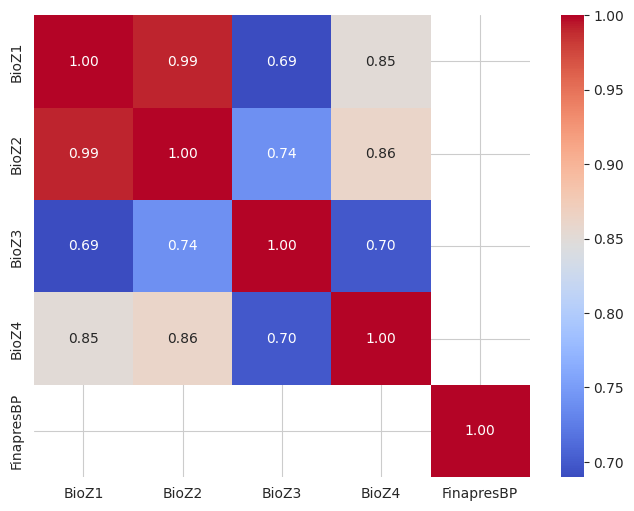

In [6]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_correlation_matrix(df, columns_to_plot)

There is no correlation between the BioZ measurements and FinapresBP because the time measurements do share overlapping timestamps (whenever one has values the other has NaNs).

In [7]:
display(df[df['FinapresBP'].notna()])
display(df[df['BioZ1'].notna()])

time  FinapresBP  Subject  Day SetupType  Setup  Trial  BioZ1  \
0       2.004923    98.48315        1    1  baseline      1      2    NaN   
1       2.009923    98.14744        1    1  baseline      1      2    NaN   
2       2.014923    97.80030        1    1  baseline      1      2    NaN   
3       2.019923    97.44237        1    1  baseline      1      2    NaN   
4       2.024923    97.07431        1    1  baseline      1      2    NaN   
...          ...         ...      ...  ...       ...    ...    ...    ...   
33834  86.575961    88.07976        1    1  baseline      1      1    NaN   
33835  86.580961    87.74439        1    1  baseline      1      1    NaN   
33836  86.585961    87.43317        1    1  baseline      1      1    NaN   
33837  86.590961    87.15423        1    1  baseline      1      1    NaN   
33838  86.595961    86.91691        1    1  baseline      1      1    NaN   

       BioZ2  BioZ3  BioZ4  
0        NaN    NaN    NaN  
1        NaN    NaN    NaN  
2        NaN    NaN    NaN  
3        NaN    NaN    NaN  
4        NaN    NaN    NaN  
...      ...    ...    ...  
33834    NaN    NaN    NaN  
33835    NaN    NaN    NaN  
33836    NaN    NaN    NaN  
33837    NaN    NaN    NaN  
33838    NaN    NaN    NaN  

[33839 rows x 11 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial     BioZ1  \
33839    1.000021         NaN        1    1  baseline      1      2  54.75861   
33840    1.000821         NaN        1    1  baseline      1      2  54.88802   
33841    1.001621         NaN        1    1  baseline      1      2  55.01903   
33842    1.002421         NaN        1    1  baseline      1      2  55.15161   
33843    1.003221         NaN        1    1  baseline      1      2  55.28571   
...           ...         ...      ...  ...       ...    ...    ...       ...   
250334  87.596021         NaN        1    1  baseline      1      1 -63.81312   
250335  87.596821         NaN        1    1  baseline      1      1 -63.46248   
250336  87.597621         NaN        1    1  baseline      1      1 -63.10261   
250337  87.598421         NaN        1    1  baseline      1      1 -62.73376   
250338  87.599221         NaN        1    1  baseline      1      1 -62.35618   

           BioZ2     BioZ3    BioZ4  
33839   19.28289  28.37978  9.61708  
33840   19.34258  28.47379  9.61511  
33841   19.40285  28.56771  9.61298  
33842   19.46372  28.66151  9.61069  
33843   19.52515  28.75516  9.60825  
...          ...       ...      ...  
250334 -24.29105   4.84010 -8.15857  
250335 -24.14836   5.12880 -8.18565  
250336 -24.00241   5.41779 -8.21183  
250337 -23.85328   5.70698 -8.23710  
250338 -23.70108   5.99626 -8.26148  

[216500 rows x 11 columns]

>##### **I'll visualise one trial to get an understanding of the data.**

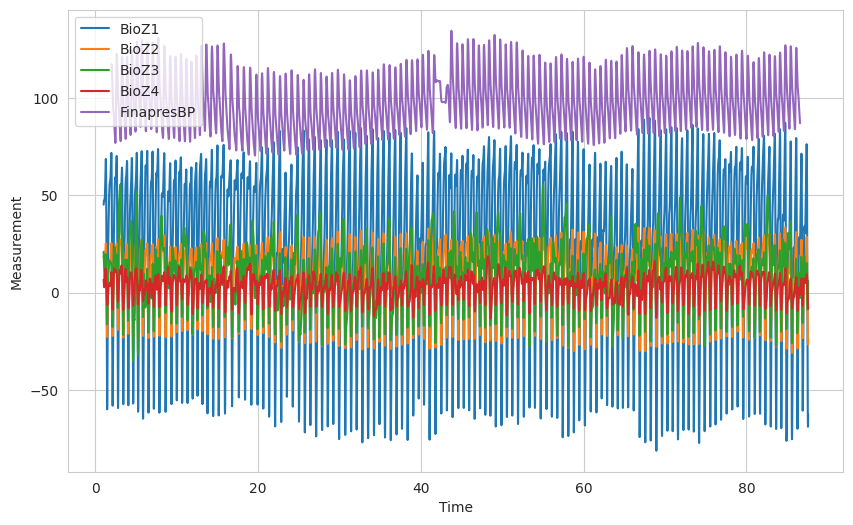

In [8]:
trial1_df = df[df['Trial'] == 1]
# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=trial1_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()

plt.show()

It's a bit cluttered. For more detail I'll limit it to a 5 second stretch

In [9]:
def plot_measurements(df, start_time, end_time):

    # Filter the DataFrame by time
    plot_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

    # Create the plot
    plt.figure(figsize=(10, 6))

    for column in columns_to_plot:
        sns.lineplot(data=plot_df, x='time', y=column, label=column)

    plt.xlabel('Time')
    plt.ylabel('Measurement')
    plt.legend()
    plt.show()

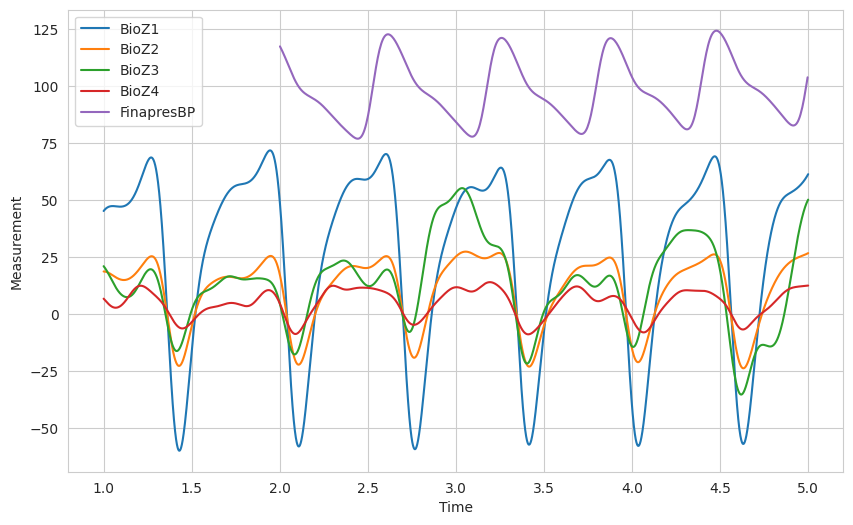

In [10]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(trial1_df, 0, 5)

We can see that the *FinapresBP* measurements start after the *BioZ* measurements.

Lets plot each Measurement directly against Blood Pressure.

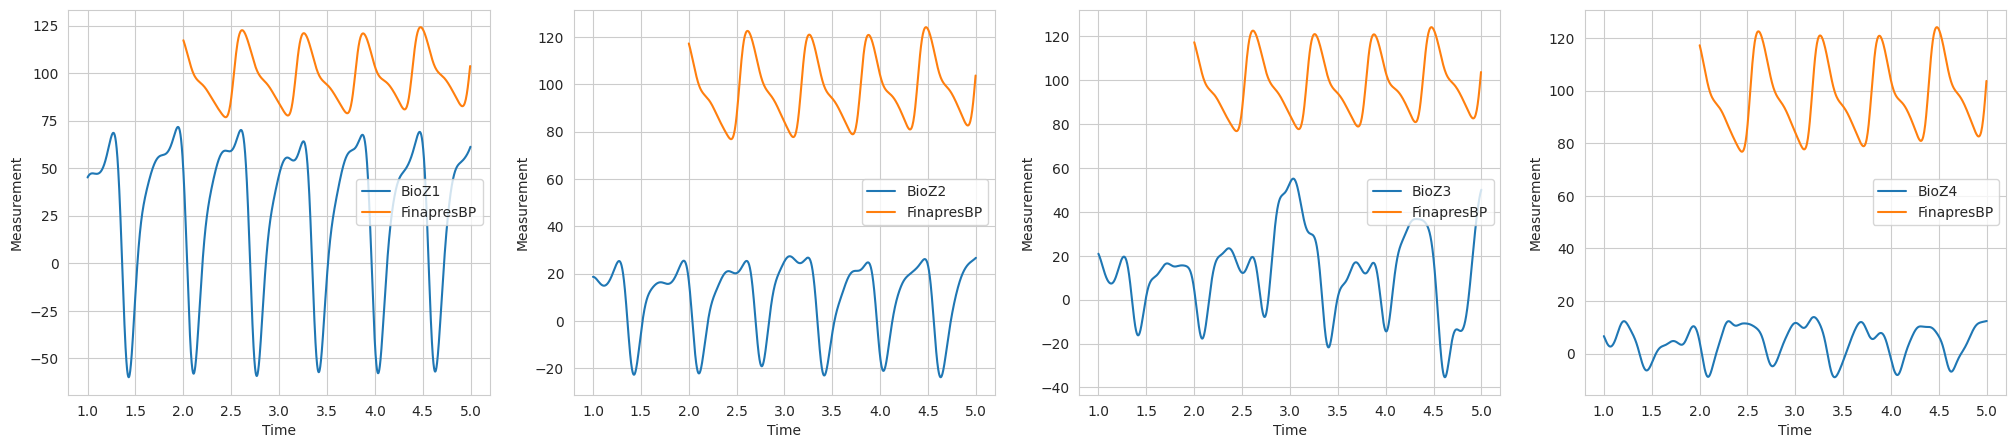

In [11]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(25, 5))

plot_df = trial1_df[(trial1_df['time'] >= 0) & (trial1_df['time'] <= 5)]

for ax, column in zip(axs, columns_to_plot):
    sns.lineplot(data=plot_df, x='time', y=column, label=column, ax=ax)
    sns.lineplot(data=plot_df, x='time', y='FinapresBP', label='FinapresBP', ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Measurement')
    ax.legend(loc='center right')

plt.show()

The two types of measurement also seem to be slightly out of phase, due to the sensor's different position on the arm.

### **1.2 Constuct a Common Time Axis**

I am going to repeat the approach from the starter notebook to create a shared time axis.

This will be shown using the first trial.

In [12]:
trial1_df = df[df['Trial']==1]
bioz_df = trial1_df.drop(columns='FinapresBP').dropna()
bp_df = trial1_df.drop(columns=['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']).dropna()
display(bioz_df)
display(bp_df)

time  Subject  Day SetupType  Setup  Trial     BioZ1     BioZ2  \
142089   1.000021        1    1  baseline      1      1  45.11402  18.60437   
142090   1.000821        1    1  baseline      1      1  45.19330  18.60317   
142091   1.001621        1    1  baseline      1      1  45.27085  18.60096   
142092   1.002421        1    1  baseline      1      1  45.34667  18.59775   
142093   1.003221        1    1  baseline      1      1  45.42077  18.59353   
...           ...      ...  ...       ...    ...    ...       ...       ...   
250334  87.596021        1    1  baseline      1      1 -63.81312 -24.29105   
250335  87.596821        1    1  baseline      1      1 -63.46248 -24.14836   
250336  87.597621        1    1  baseline      1      1 -63.10261 -24.00241   
250337  87.598421        1    1  baseline      1      1 -62.73376 -23.85328   
250338  87.599221        1    1  baseline      1      1 -62.35618 -23.70108   

           BioZ3    BioZ4  
142089  20.92109  6.67912  
142090  20.84464  6.61070  
142091  20.76674  6.54201  
142092  20.68740  6.47308  
142093  20.60664  6.40395  
...          ...      ...  
250334   4.84010 -8.15857  
250335   5.12880 -8.18565  
250336   5.41779 -8.21183  
250337   5.70698 -8.23710  
250338   5.99626 -8.26148  

[108250 rows x 10 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial
16919   2.000961   117.25990        1    1  baseline      1      1
16920   2.005961   116.50575        1    1  baseline      1      1
16921   2.010961   115.71514        1    1  baseline      1      1
16922   2.015961   114.89302        1    1  baseline      1      1
16923   2.020961   114.04378        1    1  baseline      1      1
...          ...         ...      ...  ...       ...    ...    ...
33834  86.575961    88.07976        1    1  baseline      1      1
33835  86.580961    87.74439        1    1  baseline      1      1
33836  86.585961    87.43317        1    1  baseline      1      1
33837  86.590961    87.15423        1    1  baseline      1      1
33838  86.595961    86.91691        1    1  baseline      1      1

[16920 rows x 7 columns]

> ##### **Interpolate the data onto a common time axis.**

In [13]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [14]:
start_time = max(min(bioz_df['time']), min(bp_df['time']))
end_time = min(max(bioz_df['time']), max(bp_df['time']))
common_time = np.linspace(start_time, end_time, num=len(bp_df))  # Instead of 1000 I will match the sampling rate of the Finapres data

finapres_interpolator = interp1d(bp_df['time'], bp_df['FinapresBP'], bounds_error=False, fill_value="extrapolate")
bioz1_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ1'], bounds_error=False, fill_value="extrapolate")
bioz2_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ2'], bounds_error=False, fill_value="extrapolate")
bioz3_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ3'], bounds_error=False, fill_value="extrapolate")
bioz4_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ4'], bounds_error=False, fill_value="extrapolate")

finapres_common = finapres_interpolator(common_time)
bioz1_common = bioz1_interpolator(common_time)
bioz2_common = bioz2_interpolator(common_time)
bioz3_common = bioz3_interpolator(common_time)
bioz4_common = bioz4_interpolator(common_time)

Create a dataframe with the new time axis.

In [15]:
bp_df['BioZ1'] = bioz1_common
bp_df['BioZ2'] = bioz2_common
bp_df['BioZ3'] = bioz3_common
bp_df['BioZ4'] = bioz4_common

bp_df

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
16919   2.000961   117.25990        1    1  baseline      1      1  48.332439   
16920   2.005961   116.50575        1    1  baseline      1      1  43.384880   
16921   2.010961   115.71514        1    1  baseline      1      1  37.969078   
16922   2.015961   114.89302        1    1  baseline      1      1  32.123190   
16923   2.020961   114.04378        1    1  baseline      1      1  25.896649   
...          ...         ...      ...  ...       ...    ...    ...        ...   
33834  86.575961    88.07976        1    1  baseline      1      1  20.277790   
33835  86.580961    87.74439        1    1  baseline      1      1  20.673994   
33836  86.585961    87.43317        1    1  baseline      1      1  21.228864   
33837  86.590961    87.15423        1    1  baseline      1      1  21.935641   
33838  86.595961    86.91691        1    1  baseline      1      1  22.785568   

           BioZ2     BioZ3     BioZ4  
16919  16.943260  4.337878  4.415633  
16920  15.087782  2.756093  3.484722  
16921  13.056467  1.085794  2.508537  
16922  10.864834 -0.655107  1.496772  
16923   8.532647 -2.445484  0.460766  
...          ...       ...       ...  
33834   4.039298 -2.759994 -1.125975  
33835   4.207431 -2.845577 -1.102570  
33836   4.447118 -2.823403 -1.051217  
33837   4.756011 -2.693616 -0.973220  
33838   5.130968 -2.457402 -0.870083  

[16920 rows x 11 columns]

Now that they share an axis the correlation between the ***BioZ*** and ***FinapresBP*** measurements can be examined.

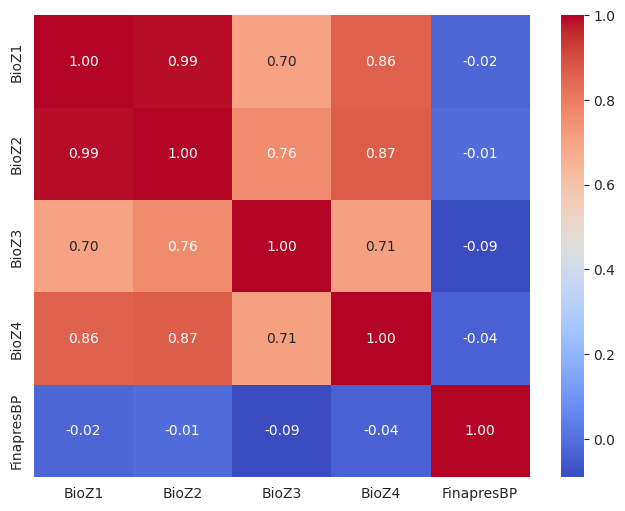

In [16]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_correlation_matrix(bp_df, columns_to_plot)

The correlation is quite low, this is most likely because the two measurements are still out of phase.

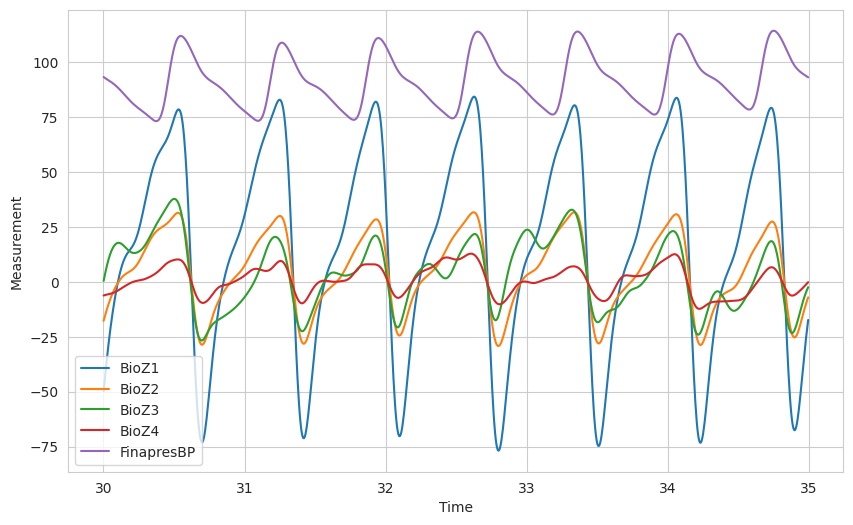

In [17]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_measurements(bp_df, 30, 35)

Lets try a regression.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
features = bp_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = bp_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 5.6739049845153655
Root Mean Squared Error: 8.279149191716565
R^2 Score: 0.6438913430721231


I'll try to improve this by making them in-phase.

> ##### **Use Cross-Correlation to align the series.**

As different, subjects might have different gaps between the measurements, I'll use cross-correlation to align the different measurements instead of a hard-coded shift.

Cross correlation compares each series at every time lag, essentially finding out how a series should be shifted to maximise correlation.

In [20]:
from scipy.signal import correlate

In [21]:
def cross_correlate(series1, series2, plot=False):

    # Normalise the series, as they each have different scales  #https://stackoverflow.com/questions/53436231/normalized-cross-correlation-in-python
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    lags = np.arange(-len(series1) + 1, len(series1))
    cross_correlation = correlate(series1, series2, mode='full')

    # Find the lag with the maximum correlation
    lag_max = lags[cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, cross_correlation)
        plt.title('Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

Invert the BioZ measurement to find the maximum correlation with Blood Pressure.

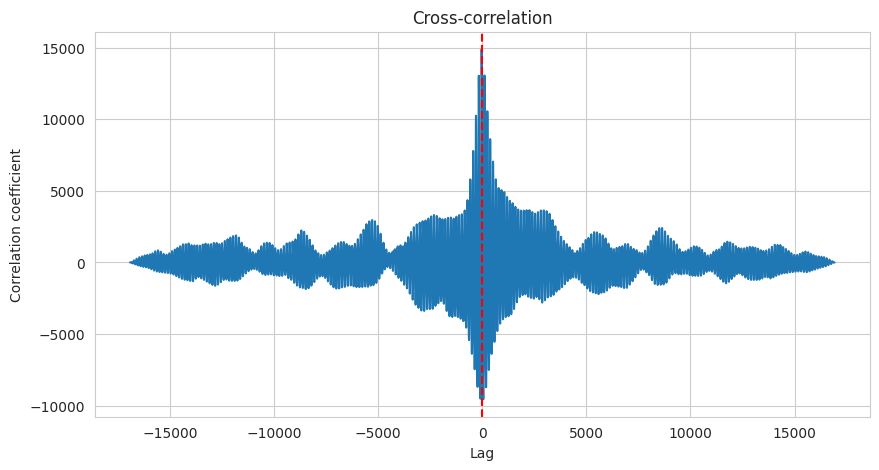

The maximum correlation is at lag -30, which equates to -0.1500 seconds.


-30

In [22]:
cross_correlate(bp_df['FinapresBP'], -1 * bp_df['BioZ1'], plot=True)

As the most highly correlated lag is negative this tells us that the ***BioZ1*** measurements occur 0.15 seconds after the ***FinpresBP*** measurements (Correlation is maximised when ***BioZ1*** is shifted back in time).

This goes against the initial hypothesis that the blood pressure measurements occur after the BioZ measurements, due to the sensor's more distant position from the heart, but I'll stick with it for now.

We can also check if the BioZ measurements are out of phase.

In [23]:
print("Cross-correlation between BioZ1 and BioZ2: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ2'])))
print("Cross-correlation between BioZ1 and BioZ3: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ3'])))
print("Cross-correlation between BioZ1 and BioZ4: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ4'])))

Cross-correlation between BioZ1 and BioZ2: 0
Cross-correlation between BioZ1 and BioZ3: 4
Cross-correlation between BioZ1 and BioZ4: 1


BioZ 1 and 2 also occur slightly after 3 and 4.

I'll align all 4 BioZ metrics to FinapresBP in order to maximise the correlation and hopefully improve regression performance.

In [24]:
aligned_df = bp_df.copy()  # Copy to avoid shifting the original df

# Shift the values based on their lag to FinapresBP
aligned_df['BioZ1'] = aligned_df['BioZ1'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ1']))
aligned_df['BioZ2'] = aligned_df['BioZ2'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ2']))
aligned_df['BioZ3'] = aligned_df['BioZ3'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ3']))
aligned_df['BioZ4'] = aligned_df['BioZ4'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ4']))

In [25]:
display(aligned_df)

# Drop the rows with NaNs at the end caused by the shift
aligned_df = aligned_df.dropna()
display(aligned_df)

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
16919   2.000961   117.25990        1    1  baseline      1      1 -38.533330   
16920   2.005961   116.50575        1    1  baseline      1      1 -34.658723   
16921   2.010961   115.71514        1    1  baseline      1      1 -30.661121   
16922   2.015961   114.89302        1    1  baseline      1      1 -26.593230   
16923   2.020961   114.04378        1    1  baseline      1      1 -22.502636   
...          ...         ...      ...  ...       ...    ...    ...        ...   
33834  86.575961    88.07976        1    1  baseline      1      1        NaN   
33835  86.580961    87.74439        1    1  baseline      1      1        NaN   
33836  86.585961    87.43317        1    1  baseline      1      1        NaN   
33837  86.590961    87.15423        1    1  baseline      1      1        NaN   
33838  86.595961    86.91691        1    1  baseline      1      1        NaN   

           BioZ2      BioZ3     BioZ4  
16919 -14.585256 -10.377965 -3.523223  
16920 -13.120392  -8.771153 -2.842555  
16921 -11.614628  -7.086624 -2.168193  
16922 -10.087884  -5.347416 -1.504652  
16923  -8.558192  -3.576163 -0.854642  
...          ...        ...       ...  
33834        NaN        NaN       NaN  
33835        NaN        NaN       NaN  
33836        NaN        NaN       NaN  
33837        NaN        NaN       NaN  
33838        NaN        NaN       NaN  

[16920 rows x 11 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
16919   2.000961   117.25990        1    1  baseline      1      1 -38.533330   
16920   2.005961   116.50575        1    1  baseline      1      1 -34.658723   
16921   2.010961   115.71514        1    1  baseline      1      1 -30.661121   
16922   2.015961   114.89302        1    1  baseline      1      1 -26.593230   
16923   2.020961   114.04378        1    1  baseline      1      1 -22.502636   
...          ...         ...      ...  ...       ...    ...    ...        ...   
33804  86.425961    99.39077        1    1  baseline      1      1  20.277790   
33805  86.430961    99.04503        1    1  baseline      1      1  20.673994   
33806  86.435961    98.69012        1    1  baseline      1      1  21.228864   
33807  86.440961    98.32703        1    1  baseline      1      1  21.935641   
33808  86.445961    97.95688        1    1  baseline      1      1  22.785568   

           BioZ2      BioZ3     BioZ4  
16919 -14.585256 -10.377965 -3.523223  
16920 -13.120392  -8.771153 -2.842555  
16921 -11.614628  -7.086624 -2.168193  
16922 -10.087884  -5.347416 -1.504652  
16923  -8.558192  -3.576163 -0.854642  
...          ...        ...       ...  
33804   4.039298  -0.818189 -1.120395  
33805   4.207431  -1.390865 -1.125975  
33806   4.447118  -1.878121 -1.102570  
33807   4.756011  -2.272390 -1.051217  
33808   5.130968  -2.567816 -0.973220  

[16890 rows x 11 columns]

The last 30 rows are dropped due to the shift of the BioZ measurements.

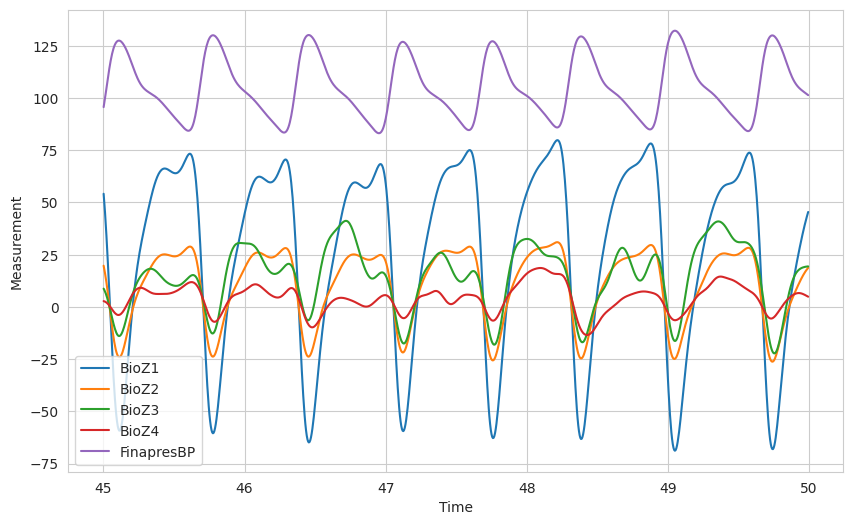

In [26]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(aligned_df, 45, 50)

The series now look visually aligned, lets see how the correlation has changed.

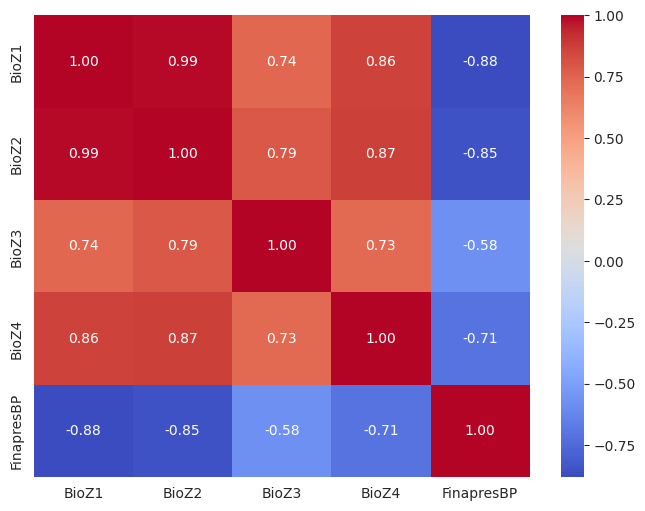

In [27]:
plot_correlation_matrix(aligned_df, columns_to_plot)

That seemed to work, the strength of the negative correlation between BioZ and BP has greatly increased.

Lets try the regression again.

In [28]:
features = aligned_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = aligned_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 3.566519977915927
Root Mean Squared Error: 4.834837954319594
R^2 Score: 0.8797910630945056


Aligning the series has greatly improved the regression performance.

> ##### **Test the assumption that *FinaPresBP* comes after *BioZ*.**

Before I perform the interpolation and cross-correlation on every trial, I want to make sure that the correct heartbeats have been aligned.

If ***FinapresBP*** does occur after ***BioZ*** the cross-correlation can be modified to only look at positive lags.

In [29]:
def cross_correlate_positive_only(series1, series2, plot=False):

    # Normalise the series, as they each have different scales
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    cross_correlation = correlate(series1, series2, mode='full')

    # Only look at the positive half of the cross correlation
    positive_cross_correlation = cross_correlation[len(cross_correlation)//2:]

    # Adjust the lags array to be the size of the positive half
    lags = np.arange(0, len(series1))

    # Find the positive lag with the maximum correlation
    lag_max = lags[positive_cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, positive_cross_correlation)
        plt.title('Positive Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

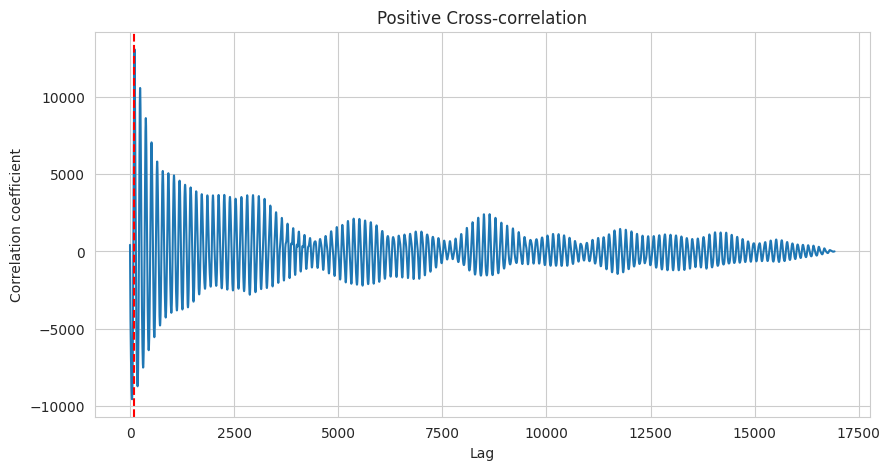

The maximum correlation is at lag 107, which equates to 0.5350 seconds.


107

In [30]:
cross_correlate_positive_only(bp_df['FinapresBP'], -1 * bp_df['BioZ1'], plot=True)

According to this approach, the ***FinapresBP*** measurements occur 0.5350 seconds after the ***BioZ*** measurements.

The BioZ measurements can be shifted back to account for this.

In [31]:
aligned_df = bp_df.copy()

# Shift the values based on their lag to FinapresBP
aligned_df['BioZ1'] = aligned_df['BioZ1'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ1']))
aligned_df['BioZ2'] = aligned_df['BioZ2'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ2']))
aligned_df['BioZ3'] = aligned_df['BioZ3'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ3']))
aligned_df['BioZ4'] = aligned_df['BioZ4'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ4']))

In [32]:
display(aligned_df)

# Drop the rows with NaNs at the end caused by the shift
aligned_df = aligned_df.dropna()
display(aligned_df)

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
16919   2.000961   117.25990        1    1  baseline      1      1        NaN   
16920   2.005961   116.50575        1    1  baseline      1      1        NaN   
16921   2.010961   115.71514        1    1  baseline      1      1        NaN   
16922   2.015961   114.89302        1    1  baseline      1      1        NaN   
16923   2.020961   114.04378        1    1  baseline      1      1        NaN   
...          ...         ...      ...  ...       ...    ...    ...        ...   
33834  86.575961    88.07976        1    1  baseline      1      1  56.521973   
33835  86.580961    87.74439        1    1  baseline      1      1  58.185035   
33836  86.585961    87.43317        1    1  baseline      1      1  59.849865   
33837  86.590961    87.15423        1    1  baseline      1      1  61.516974   
33838  86.595961    86.91691        1    1  baseline      1      1  63.185431   

           BioZ2     BioZ3     BioZ4  
16919        NaN       NaN       NaN  
16920        NaN       NaN       NaN  
16921        NaN       NaN       NaN  
16922        NaN       NaN       NaN  
16923        NaN       NaN       NaN  
...          ...       ...       ...  
33834  21.938780  6.793856  4.570112  
33835  22.680968  7.547988  4.617755  
33836  23.416500  8.308917  4.667222  
33837  24.144429  9.071360  4.724163  
33838  24.863309  9.830272  4.793784  

[16920 rows x 11 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
17030   2.555961   112.20797        1    1  baseline      1      1  25.896649   
17031   2.560961   114.09118        1    1  baseline      1      1  19.354285   
17032   2.565961   115.75133        1    1  baseline      1      1  12.571705   
17033   2.570961   117.19370        1    1  baseline      1      1   5.633771   
17034   2.575961   118.49058        1    1  baseline      1      1  -1.366571   
...          ...         ...      ...  ...       ...    ...    ...        ...   
33834  86.575961    88.07976        1    1  baseline      1      1  56.521973   
33835  86.580961    87.74439        1    1  baseline      1      1  58.185035   
33836  86.585961    87.43317        1    1  baseline      1      1  59.849865   
33837  86.590961    87.15423        1    1  baseline      1      1  61.516974   
33838  86.595961    86.91691        1    1  baseline      1      1  63.185431   

           BioZ2     BioZ3     BioZ4  
17030   8.532647  4.337878  1.496772  
17031   6.085352  2.756093  0.460766  
17032   3.552295  1.085794 -0.586344  
17033   0.966089 -0.655107 -1.630163  
17034  -1.637821 -2.445484 -2.655336  
...          ...       ...       ...  
33834  21.938780  6.793856  4.570112  
33835  22.680968  7.547988  4.617755  
33836  23.416500  8.308917  4.667222  
33837  24.144429  9.071360  4.724163  
33838  24.863309  9.830272  4.793784  

[16809 rows x 11 columns]

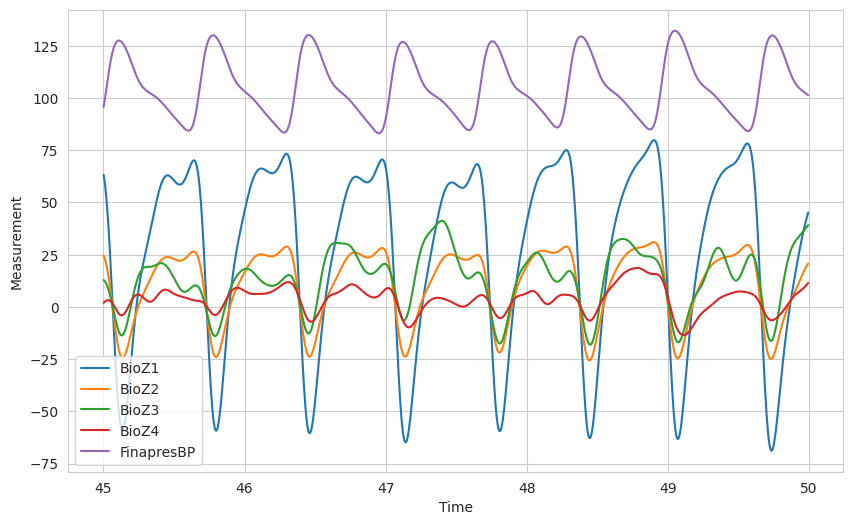

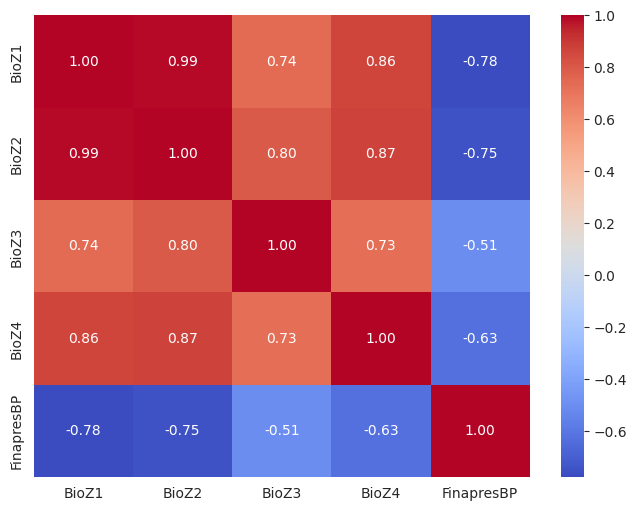

In [33]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(aligned_df, 45, 50)

plot_correlation_matrix(aligned_df, columns_to_plot)

Once, again, the spectra are visually aligned and the correlations have increased.

However the correlations are less significant, lets look at how the regression model performs.

In [34]:
features = aligned_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = aligned_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 5.139353640124925
Root Mean Squared Error: 8.017656650317205
R^2 Score: 0.6725722187618131


This is quite a bit worse.

Based on the lower correlation and worse model performance, I am going to stick with the first approach for now and follow the assumption that blood pressure measurements occur first.

### **1.2 Now I'll repeat this with all of the CSVs**

> ##### **Load and Interpolate the ***BioZ*** and ***Finapres*** data from every trial.**

Trying to perform interpolation on the fully loaded dataset has too large of a memory footprint, as a result it is performed on each trial as it gets imported.

In [35]:
def interpolate_trial(bioz_df, bp_df):

    start_time = max(min(bioz_df['time']), min(bp_df['time']))
    end_time = min(max(bioz_df['time']), max(bp_df['time']))
    common_time = np.linspace(start_time, end_time, num=len(bp_df))  # Instead of 1000 I will match the sampling rate of the Finapres data

    #finapres_interpolator = interp1d(bp_df['time'], bp_df['FinapresBP'], bounds_error=False, fill_value="extrapolate")  # Not needed as this axis is left alone
    bioz1_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ1'], bounds_error=False, fill_value="extrapolate")
    bioz2_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ2'], bounds_error=False, fill_value="extrapolate")
    bioz3_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ3'], bounds_error=False, fill_value="extrapolate")
    bioz4_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ4'], bounds_error=False, fill_value="extrapolate")

    # finapres_common = finapres_interpolator(common_time)
    bioz1_common = bioz1_interpolator(common_time)
    bioz2_common = bioz2_interpolator(common_time)
    bioz3_common = bioz3_interpolator(common_time)
    bioz4_common = bioz4_interpolator(common_time)

    bp_df['BioZ1'] = bioz1_common
    bp_df['BioZ2'] = bioz2_common
    bp_df['BioZ3'] = bioz3_common
    bp_df['BioZ4'] = bioz4_common

    return bp_df

In [36]:
dfs = []

# Set this to the to the root folder of the data
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0"

# Get all of the subject folders
subject_folders = glob.glob(os.path.join(path, "*" + os.sep))  # os.sep ensures that only directories are matched

# Iterate over each subject folder and examine each setup folder
for subject_folder in subject_folders:
    setup_folders = glob.glob(os.path.join(subject_folder, "*" + os.sep))

    # Iterate over each setup folder adding the CSVs within
    for setup_folder in setup_folders:
        trial_files = glob.glob(os.path.join(setup_folder, "*.csv"))

        # Create a dictionary mapping trials to their files
        trial_dict = {}
        for f in trial_files:
            f = f.replace("\\", "/")
            trial = f.split("/")[-1].split('_')[1] # Extract the trial name
            if trial in trial_dict:
                trial_dict[trial].append(f)
            else:
                trial_dict[trial] = [f]

        # Process each trial
        for trial, files in trial_dict.items():

            # Get the BioZ and BP measurements
            bioz_file = next((f for f in files if 'bioz.csv' in f), None)
            bp_file = next((f for f in files if 'finapresBP.csv' in f), None)

            # Extract the trial, setup and subject info from the file path
            bioz_file = bioz_file.replace("\\", "/")
            trial_string = bioz_file.split("/")[-1]
            setup_string = bioz_file.split("/")[-2]
            subject_string = bioz_file.split("/")[-3]

            # Process the strings into keys
            trial = int(trial_string.split('_')[1].replace('trial', ''))
            setup_type = setup_string.split('_')[1]  # Include the type of experiment done
            setup = int(setup_string.split('_')[0].replace('setup', ''))

            # Day and subject should also be split so that subject 1 is properly accounted for
            # This should prevent data leakage across folds later on
            day = int(subject_string.split('_')[1].replace("day", ""))
            subject = int(subject_string.split('_')[0].replace("subject", ""))
            
            # Read CSVs and add trial identifiers
            bioz_df = pd.read_csv(bioz_file)
            bp_df = pd.read_csv(bp_file)

            # Add identifiers to DataFrames
            for df in (bioz_df, bp_df):
                df['Subject'] = subject
                df['Day'] = day
                df['SetupType'] = setup_type
                df['Setup'] = setup
                df['Trial'] = trial

            # Subject 7 has no BioZ4 measurements so I'll create the column
            if 'BioZ4' not in bioz_df.columns:
                bioz_df['BioZ4'] = np.nan
            
            # Interpolate and merge bioz into bp dataframe for the trial
            merged_df = interpolate_trial(bioz_df, bp_df)
            dfs.append(merged_df)
                       
df = pd.concat(dfs, ignore_index=True)

Add a bit more structure to the dataset, ordering columns by granularity.

In [37]:
df = df[['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'time', 'BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']]
display(df)
df.info()
df.describe()
df.isna().sum()
# df.to_csv("../../data/interpolated_trials.csv", index=False)

Subject  Day SetupType  Setup  Trial       time      BioZ1  \
0              4    1      hgcp      3     12   2.001273  13.448716   
1              4    1      hgcp      3     12   2.006273  14.398632   
2              4    1      hgcp      3     12   2.011273  15.394391   
3              4    1      hgcp      3     12   2.016273  16.429643   
4              4    1      hgcp      3     12   2.021273  17.496892   
...          ...  ...       ...    ...    ...        ...        ...   
4460467        1    1      hgcp      7     29  86.576755 -42.969754   
4460468        1    1      hgcp      7     29  86.581755 -46.209377   
4460469        1    1      hgcp      7     29  86.586755 -48.872887   
4460470        1    1      hgcp      7     29  86.591755 -50.953787   
4460471        1    1      hgcp      7     29  86.596755 -52.456518   

             BioZ2      BioZ3     BioZ4  FinapresBP  
0        -7.072506  25.092134 -2.859797    61.51059  
1        -7.974001  25.644244 -2.938438    61.43445  
2        -8.858218  26.312434 -2.953724    61.33912  
3        -9.726161  27.093175 -2.905668    61.22310  
4       -10.578904  27.980004 -2.795309    61.08539  
...            ...        ...       ...         ...  
4460467 -14.640517 -24.377147 -0.884836   139.61385  
4460468 -15.719765 -25.092277 -1.277057   138.12162  
4460469 -16.625495 -25.493273 -1.682027   136.61745  
4460470 -17.357463 -25.578663 -2.102113   135.11783  
4460471 -17.918651 -25.352379 -2.539637   133.63829  

[4460472 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460472 entries, 0 to 4460471
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Subject     int64  
 1   Day         int64  
 2   SetupType   object 
 3   Setup       int64  
 4   Trial       int64  
 5   time        float64
 6   BioZ1       float64
 7   BioZ2       float64
 8   BioZ3       float64
 9   BioZ4       float64
 10  FinapresBP  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 374.3+ MB


Subject            0
Day                0
SetupType          0
Setup              0
Trial              0
time               0
BioZ1              0
BioZ2              0
BioZ3              0
BioZ4         112197
FinapresBP         0
dtype: int64

The NaNs in BioZ4 are caused by subject 7. To avoid issues when aligning, for now I am going to set subject 7's BioZ4 to equal BioZ3 as these two metrics are related.

In [38]:
df.loc[df['Subject'] == 7, 'BioZ4'] = df['BioZ3']

Each unique trial is identified by the combination of the Subject, Day and Trial keys (This is because subject 1's trial ids reset to 1 on day 4).

We can see that 260 unique trials have taken place.

In [39]:
len(df[['Subject', 'Day', 'Trial']].drop_duplicates())

260

The number of trials of each type.

In [40]:
unique_trials = df.groupby(['SetupType', 'Subject', 'Day', 'Trial']).size().reset_index(name='Counts')

# Now, count the unique trials for each 'SetupType'
trial_counts = unique_trials.groupby('SetupType').size()
print(trial_counts)

SetupType
baseline     16
cycling       3
hgcp        214
rest          1
valsalva     26
dtype: int64


Lets inspect the full dataset by plotting unique trials and the correlation matrix.

All of the visualised trials can be seen in the [Plotting_All_Trials](./Plotting_All_Trials.ipynb) notebook.

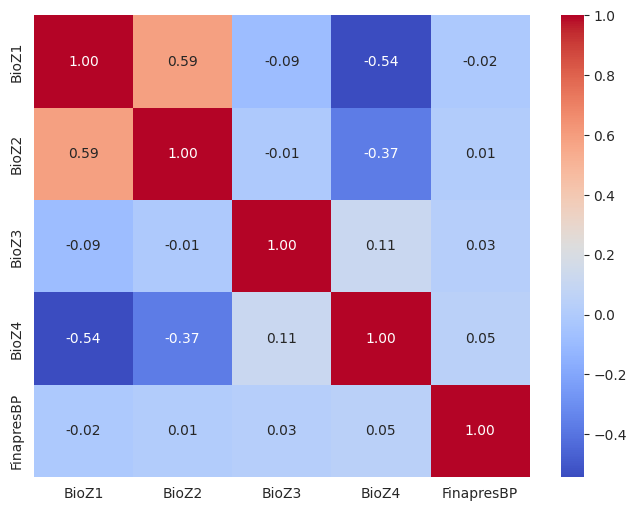

In [41]:
plot_correlation_matrix(df, columns_to_plot)

The low correlation and manual inspection indicates that the lack of alignment is common across the trials.

Additionally, some of the more intense SetupTypes seem to cause severe fluctuations in the BioZ metrics. These might have to be dealt with later.

Here is one hgcp trial that looks especially suspicious

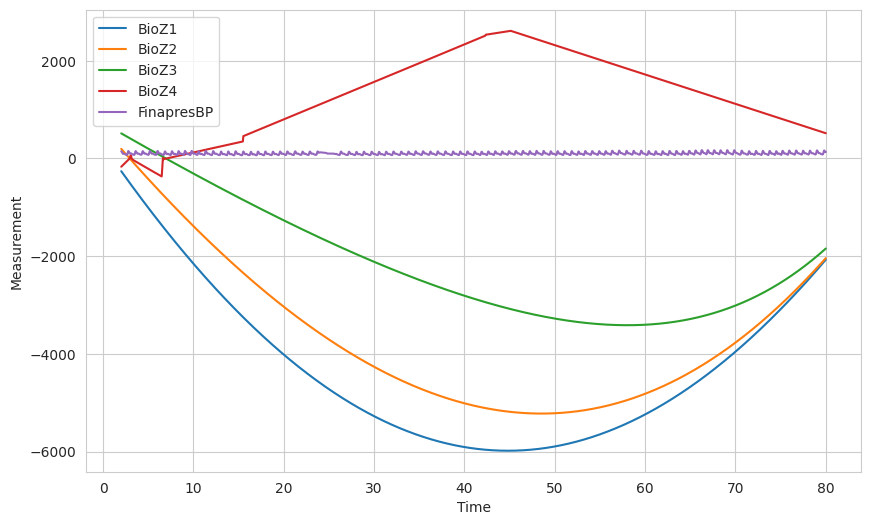

In [42]:
trial_index = (3, 1, 24)  # The selected trial
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
plot_measurements(grouped_trials.get_group(trial_index), 0, 80)

For comparison I'll perform a regression on a subset of the data.

##### **In their approach, a separate model is trained for each subject and performance is based on the average of all of the models**.

At the currrent level of granularity there is too much data to train the model on without crashing.

To alleviate this I will downsample the data lowering the time resolution.

Currently the data is sampled at 200 Hz which is 1 sample every 5 milliseconds.

In [43]:
def resample_group(group, granularity='50ms'):

    resampled_group = group.copy()

    # Convert the time column to timedelta and set as index
    resampled_group['time'] = pd.to_timedelta(resampled_group['time'], 's')
    resampled_group = resampled_group.set_index('time')

    # Resample
    resampled_group = resampled_group.resample(granularity).mean()
    resampled_group = resampled_group.reset_index()
    
    return resampled_group

grouped_trials = df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)  # I'm not sure why this gets added
resampled_df

Subject  Day SetupType  Setup  Trial                      time  \
0             1    1  baseline      1      1 0 days 00:00:02.000961333   
1             1    1  baseline      1      1 0 days 00:00:02.050961333   
2             1    1  baseline      1      1 0 days 00:00:02.100961333   
3             1    1  baseline      1      1 0 days 00:00:02.150961333   
4             1    1  baseline      1      1 0 days 00:00:02.200961333   
...         ...  ...       ...    ...    ...                       ...   
446059        7    1   cycling      1      3    0 days 00:03:08.754952   
446060        7    1   cycling      1      3    0 days 00:03:08.804952   
446061        7    1   cycling      1      3    0 days 00:03:08.854952   
446062        7    1   cycling      1      3    0 days 00:03:08.904952   
446063        7    1   cycling      1      3    0 days 00:03:08.954952   

            BioZ1      BioZ2      BioZ3      BioZ4  FinapresBP  
0       21.556915   6.922896  -3.386628  -0.073681  113.520806  
1      -39.157956 -15.519125 -16.243995  -7.756720  104.610824  
2      -52.898600 -20.144582 -10.678291  -6.272398   98.157442  
3      -20.598913  -7.873248   5.571342   0.042631   95.127747  
4       13.507497   4.512397  16.603168   6.070578   92.523687  
...           ...        ...        ...        ...         ...  
446059 -32.902071  -4.780745 -18.104029 -18.104029   79.232191  
446060 -37.933496  -5.078346 -23.184047 -23.184047   75.247921  
446061 -39.708873  -4.805144 -25.869283 -25.869283   72.009278  
446062 -29.890967  -3.448730 -24.425531 -24.425531   69.537803  
446063 -13.114719  -1.492005 -19.149537 -19.149537   67.690388  

[446064 rows x 11 columns]

This plots a resampled trial.

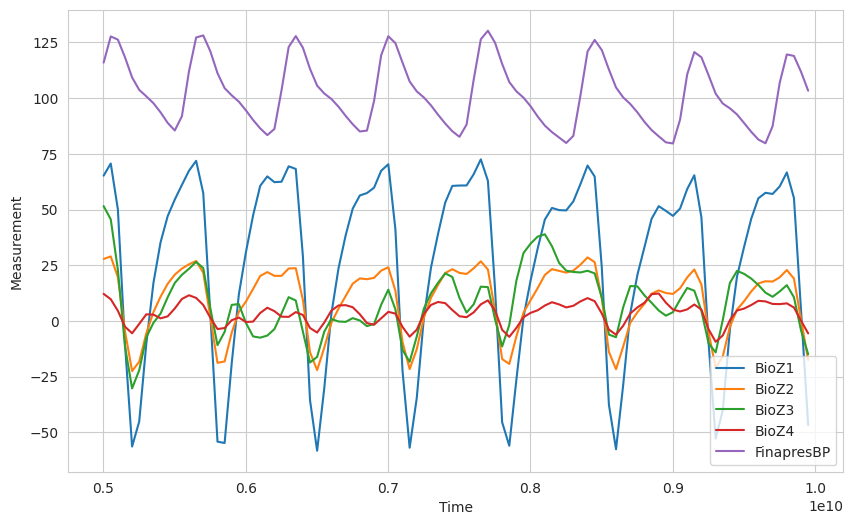

In [44]:
trial_index = (1, 1, 1)
start_time = pd.to_timedelta('5 seconds')
end_time = pd.to_timedelta('10 seconds')

grouped_trials = resampled_df.groupby(['Subject', 'Day', 'Trial'])
trial = grouped_trials.get_group(trial_index)
plot_measurements(trial, start_time, end_time)

I'll copy their subject based approach for now, although I'll use an 80-20 split initially.

In [45]:
def train_and_evaluate_rf_regressor(df, features=['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4'], test_size=0.2, n_estimators=100, show_subject_performance=False):

    maes = []
    rmses = []
    r2s = []

    # Initialise the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=1234)

    # Loop over each Subject
    for subject in range(1, 8):

        # Filter the dataframe by the subject
        subject_df = resampled_df[resampled_df['Subject'] == subject]
        # Extract features and target from the DataFrame
        X = subject_df[features].values
        y = subject_df['FinapresBP'].values

        try:

            # Split the dataset into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Calculate performance metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = mse ** 0.5
            r2 = r2_score(y_test, y_pred)

            # Add the results to their lists
            maes.append(mae)
            rmses.append(rmse)
            r2s.append(r2)

        # This is for checking by setup type
        except ValueError:
            next


        # Plot the results for each subject
        if show_subject_performance:

            # Print the performance metrics
            print(f'Metrics for Subject {subject}:')
            print(f'Mean Absolute Error: {mae}')
            print(f'Root Mean Squared Error: {rmse}')
            print(f'R^2 Score: {r2}')
            print()

    # Print the average metrics across the subjects
    print(f'Average Metrics:')
    print(f'Mean Absolute Error: {np.mean(maes)} +- {np.std(maes)}')
    print(f'Root Mean Squared Error: {np.mean(rmses)} +- {np.std(rmses)}')
    print(f'R^2 Score: {np.mean(r2s)} +- {np.std(r2s)}')

In [46]:
grouped_trials = df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

train_and_evaluate_rf_regressor(resampled_df, show_subject_performance=True)

Metrics for Subject 1:
Mean Absolute Error: 12.918770109048596
Root Mean Squared Error: 16.625768872640844
R^2 Score: 0.15163921709967776

Metrics for Subject 2:
Mean Absolute Error: 12.522008337444923
Root Mean Squared Error: 16.062490495001786
R^2 Score: 0.24636933700995578

Metrics for Subject 3:
Mean Absolute Error: 15.043166590652648
Root Mean Squared Error: 19.95262386373638
R^2 Score: 0.2556836394903712

Metrics for Subject 4:
Mean Absolute Error: 16.0448479035905
Root Mean Squared Error: 20.089291100839578
R^2 Score: 0.04781722147951306

Metrics for Subject 5:
Mean Absolute Error: 16.39686371035657
Root Mean Squared Error: 20.979894572306804
R^2 Score: 0.08703204691704403

Metrics for Subject 6:
Mean Absolute Error: 16.388990801053378
Root Mean Squared Error: 20.903826883234494
R^2 Score: 0.05260828884893398

Metrics for Subject 7:
Mean Absolute Error: 13.04843930366576
Root Mean Squared Error: 17.216620397168835
R^2 Score: 0.1151887882698649

Average Metrics:
Mean Absolute Err

Metrics for Subject 1:
Mean Absolute Error: 12.918770109048596
Root Mean Squared Error: 16.625768872640844
R^2 Score: 0.15163921709967776


Metrics for Subject 2:
Mean Absolute Error: 12.522008337444923
Root Mean Squared Error: 16.062490495001786
R^2 Score: 0.24636933700995578


Metrics for Subject 3:
Mean Absolute Error: 15.043166590652648
Root Mean Squared Error: 19.95262386373638
R^2 Score: 0.2556836394903712


Metrics for Subject 4:
Mean Absolute Error: 16.0448479035905
Root Mean Squared Error: 20.089291100839578
R^2 Score: 0.04781722147951306

Metrics for Subject 5:
Mean Absolute Error: 16.39686371035657
Root Mean Squared Error: 20.979894572306804
R^2 Score: 0.08703204691704403

Metrics for Subject 6:
Mean Absolute Error: 16.388990801053378
Root Mean Squared Error: 20.903826883234494
R^2 Score: 0.05260828884893398

Metrics for Subject 7:
Mean Absolute Error: 13.04843930366576
Root Mean Squared Error: 17.216620397168835
R^2 Score: 0.1151887882698649

Average Metrics:
Mean Absolute Error: 14.623298107973197 +- 1.6151653453116852
Root Mean Squared Error: 18.832930883561243 +- 1.9599409745157956
R^2 Score: 0.1366197913021944 +- 0.0795602261681304

Obviously this is quite poor, lets see how alignment changes it.

> ##### **Align the Full Dataset with Cross-Correlation.**

First I'll print the alignment of BP to BioZ across each trial.

In [47]:
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

for trial_name, trial in grouped_trials:

    # Show the alignment of FinapresBP and BioZ
    print(f'Trial: {trial_name}')

    for bioz in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        cross_correlation = cross_correlate(trial['FinapresBP'], -1*trial[bioz])
        print(f'{bioz}: {cross_correlation}')
    print()

Trial: (1, 1, 1)
BioZ1: -30
BioZ2: -30
BioZ3: -25
BioZ4: -29

Trial: (1, 1, 2)
BioZ1: -30
BioZ2: -30
BioZ3: -24
BioZ4: -28

Trial: (1, 1, 3)
BioZ1: -31
BioZ2: -31
BioZ3: -26
BioZ4: -30

Trial: (1, 1, 4)
BioZ1: -32
BioZ2: -32
BioZ3: -26
BioZ4: -31

Trial: (1, 1, 5)
BioZ1: -29
BioZ2: -30
BioZ3: -23
BioZ4: -30

Trial: (1, 1, 6)
BioZ1: -31
BioZ2: -32
BioZ3: -28
BioZ4: -30

Trial: (1, 1, 7)
BioZ1: -30
BioZ2: -30
BioZ3: -26
BioZ4: -29

Trial: (1, 1, 8)
BioZ1: -28
BioZ2: -27
BioZ3: 5816
BioZ4: -23

Trial: (1, 1, 9)
BioZ1: -29
BioZ2: -28
BioZ3: 6958
BioZ4: -23

Trial: (1, 1, 10)
BioZ1: -28
BioZ2: -27
BioZ3: -4055
BioZ4: -26

Trial: (1, 1, 11)
BioZ1: -29
BioZ2: -29
BioZ3: -5677
BioZ4: -25

Trial: (1, 1, 12)
BioZ1: -28
BioZ2: -27
BioZ3: -558
BioZ4: -23

Trial: (1, 1, 13)
BioZ1: -29
BioZ2: -29
BioZ3: 2317
BioZ4: -33

Trial: (1, 1, 14)
BioZ1: -30
BioZ2: -30
BioZ3: 6768
BioZ4: -34

Trial: (1, 1, 15)
BioZ1: -29
BioZ2: -29
BioZ3: -13717
BioZ4: -28

Trial: (1, 1, 16)
BioZ1: -29
BioZ2: -29
BioZ3: 9014


There appear to be some quite severe outliers, where the most correlated shift is very distant.

Shift each trial, aligning the series.

In [48]:
def align_group(group):
    aligned_group = group.copy() # Copy to avoid modifying the original dataframe
    
    for bioz_column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        shift_value = cross_correlate(aligned_group['FinapresBP'], -1 * aligned_group[bioz_column])
        aligned_group[bioz_column] = aligned_group[bioz_column].shift(shift_value)
    
    return aligned_group

# Group each trial
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

# Apply the function to each group and combine the results
aligned_df = grouped_trials.apply(align_group, include_groups=True).reset_index(drop=True)

/tmp/ipykernel_26596/41769967.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = grouped_trials.apply(align_group, include_groups=True).reset_index(drop=True)


In [49]:
aligned_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961 -38.533330   
1              1    1  baseline      1      1    2.005961 -34.658723   
2              1    1  baseline      1      1    2.010961 -30.661121   
3              1    1  baseline      1      1    2.015961 -26.593230   
4              1    1  baseline      1      1    2.020961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4460467        7    1   cycling      1      3  188.974952        NaN   
4460468        7    1   cycling      1      3  188.979952        NaN   
4460469        7    1   cycling      1      3  188.984952        NaN   
4460470        7    1   cycling      1      3  188.989952        NaN   
4460471        7    1   cycling      1      3  188.994952        NaN   

             BioZ2      BioZ3     BioZ4  FinapresBP  
0       -14.585256 -10.377965 -3.523223   117.25990  
1       -13.120392  -8.771153 -2.842555   116.50575  
2       -11.614628  -7.086624 -2.168193   115.71514  
3       -10.087884  -5.347416 -1.504652   114.89302  
4        -8.558192  -3.576163 -0.854642   114.04378  
...            ...        ...       ...         ...  
4460467        NaN        NaN       NaN    67.67920  
4460468        NaN        NaN       NaN    67.50756  
4460469        NaN        NaN       NaN    67.33915  
4460470        NaN        NaN       NaN    67.17298  
4460471        NaN        NaN       NaN    67.00795  

[4460472 rows x 11 columns]

In [50]:
def show_bioz_shift(df=aligned_df):
    bioz_columns = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']
    print('Shift')
    display(aligned_df[bioz_columns].isna().sum())
    print('Average Shift Per Trial')
    display(aligned_df[bioz_columns].isna().sum() / 260)  # Average shift per trial


In [51]:
show_bioz_shift()

Shift


BioZ1     97494
BioZ2    147125
BioZ3    208450
BioZ4    130473
dtype: int64

Average Shift Per Trial


BioZ1    374.976923
BioZ2    565.865385
BioZ3    801.730769
BioZ4    501.819231
dtype: float64

Drop the NaNs created by each shift

In [52]:
aligned_df = aligned_df.dropna()
display(aligned_df)

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961 -38.533330   
1              1    1  baseline      1      1    2.005961 -34.658723   
2              1    1  baseline      1      1    2.010961 -30.661121   
3              1    1  baseline      1      1    2.015961 -26.593230   
4              1    1  baseline      1      1    2.020961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4460429        7    1   cycling      1      3  188.784952 -14.835259   
4460430        7    1   cycling      1      3  188.789952 -12.991598   
4460431        7    1   cycling      1      3  188.794952 -11.185842   
4460432        7    1   cycling      1      3  188.799952  -9.428160   
4460433        7    1   cycling      1      3  188.804952  -7.727173   

             BioZ2      BioZ3      BioZ4  FinapresBP  
0       -14.585256 -10.377965  -3.523223   117.25990  
1       -13.120392  -8.771153  -2.842555   116.50575  
2       -11.614628  -7.086624  -2.168193   115.71514  
3       -10.087884  -5.347416  -1.504652   114.89302  
4        -8.558192  -3.576163  -0.854642   114.04378  
...            ...        ...        ...         ...  
4460429  -1.507162 -20.421111 -20.421111    78.58829  
4460430  -1.269116 -19.776869 -19.776869    78.16795  
4460431  -1.026987 -19.132283 -19.132283    77.75340  
4460432  -0.781154 -18.493100 -18.493100    77.34540  
4460433  -0.531917 -17.864842 -17.864842    76.94324  

[4107277 rows x 11 columns]

Unfortunately due to noisy data, not every trial finds a local alignment, instead a large proportion of the data gets shifted and dropped. One trial gets removed completely,

In [53]:
print(f"Rows Dropped: {len(df) - len(aligned_df)}")
print(f"Trial Count: {len(aligned_df[['Subject', 'Day', 'Trial']].drop_duplicates())}")

Rows Dropped: 353195
Trial Count: 259


I'll visualise a trial before and after alignment.

In [54]:
def plot_alignment(df, aligned_df, trial_index, start_time=50, end_time=55):
    print('Before Alignment')
    grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
    trial = grouped_trials.get_group(trial_index)
    plot_measurements(trial, start_time, end_time)

    print('After Alignment')
    grouped_trials = aligned_df.groupby(['Subject', 'Day', 'Trial'])
    trial = grouped_trials.get_group(trial_index)
    plot_measurements(trial, start_time, end_time)

Before Alignment


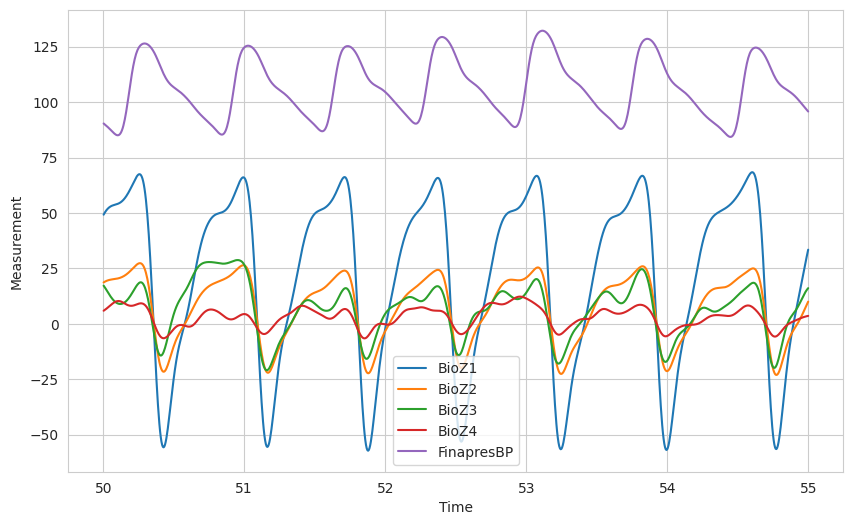

After Alignment


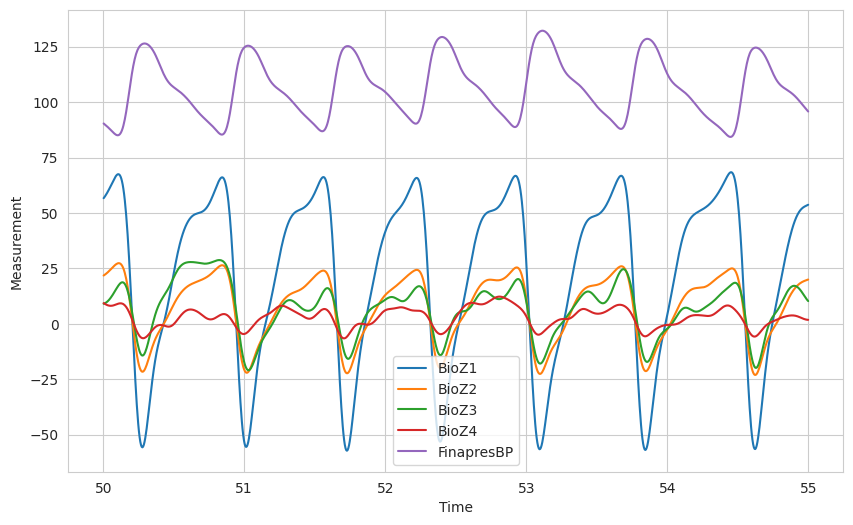

In [55]:
trial_index = (1, 1, 7)  # The selected trial
plot_alignment(df, aligned_df, trial_index, 50, 55)

This one works quite well, most of the metrics are lined up.

Before Alignment


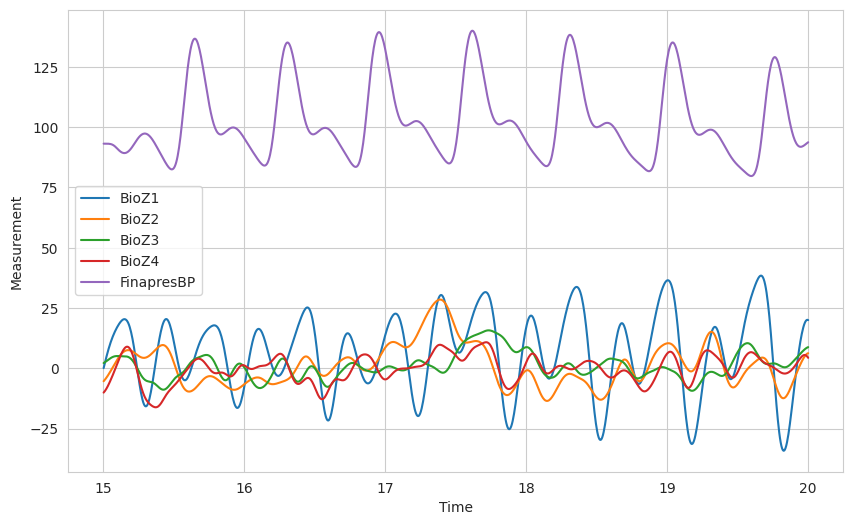

After Alignment


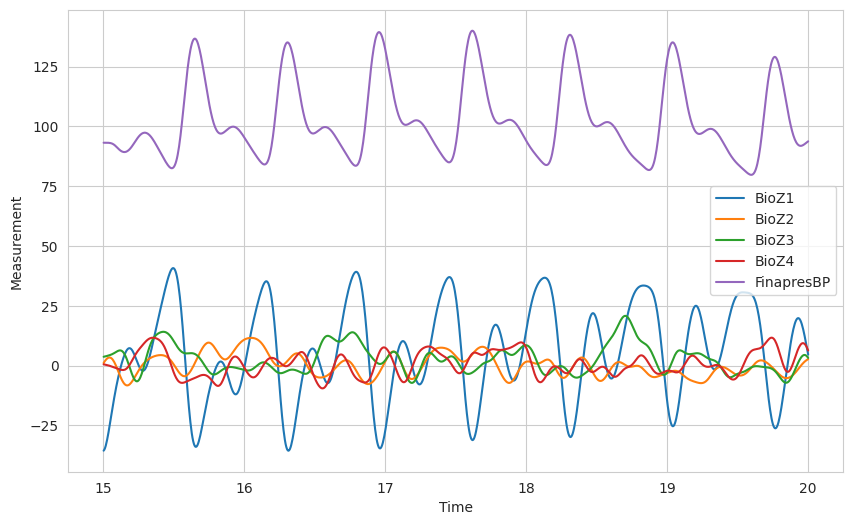

In [56]:
trial_index = (2, 1, 40)
plot_alignment(df, aligned_df, trial_index, 15, 20)

Over half of this series gets deleted in the shifting process.

Before Alignment


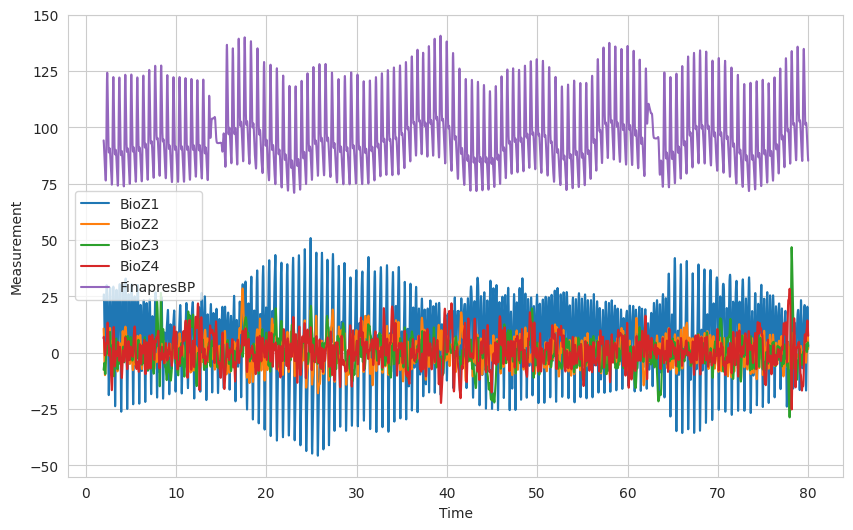

After Alignment


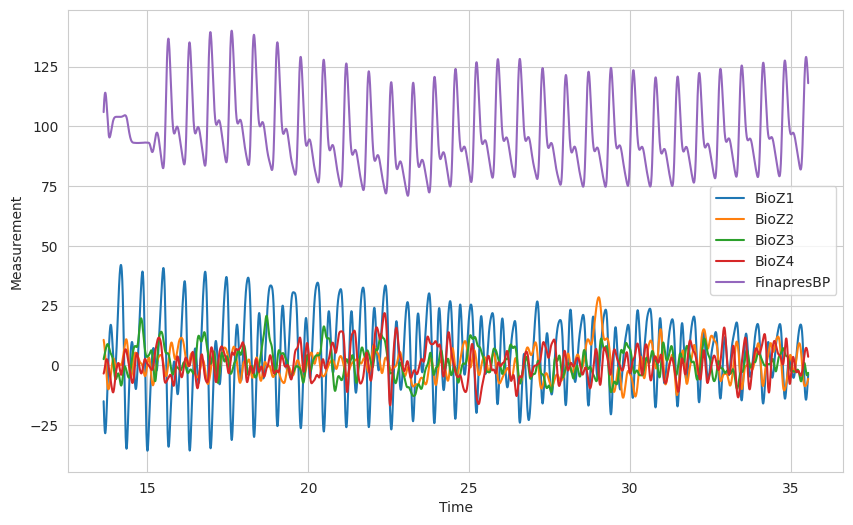

In [57]:
plot_alignment(df, aligned_df ,trial_index, 0, 80) 

Whereas in this trial, some of the metrics are heavily shifted, and corresponding metrics are not properly aligned.

The correlation plot below also indicates that the shifting approach has not been fully successful.

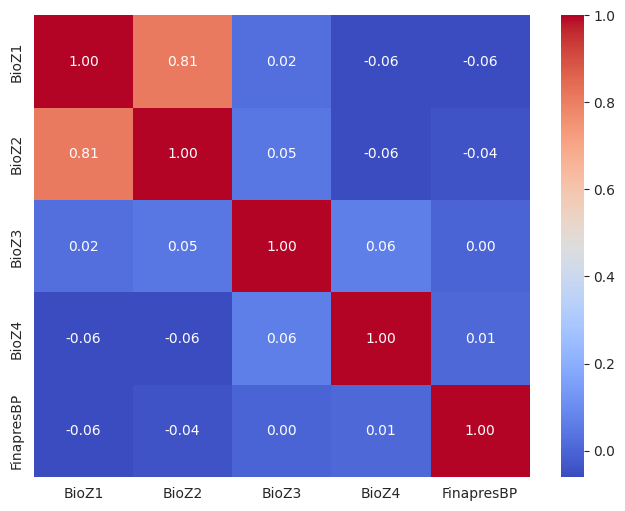

In [58]:
plot_correlation_matrix(aligned_df, columns_to_plot)

I'll see how alignment impacted the regression.

In [59]:
grouped_trials = aligned_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Average Metrics:

Mean Absolute Error: 11.015655319541265 +- 2.104336092598613

Root Mean Squared Error: 14.391241980352598 +- 2.388246760756765

R^2 Score: 0.5037662272968073 +- 0.11578192444415743

Despite some of the misalignment the scores have improved.

In [60]:
#aligned_df.to_csv("../../data/full_aligned_df.csv", index=False)

> ##### **Evaluate the model on each SetupType.**

In [61]:
# for setup_type in df['SetupType'].unique():

#     setup_df = aligned_df[aligned_df['SetupType'] == setup_type]

#     grouped_trials = setup_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
#     resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
#     resampled_df.drop(columns=['level_5'], inplace=True)

#     print(setup_type)
#     train_and_evaluate_rf_regressor(resampled_df)
#     print()

baseline
Average Metrics:
Mean Absolute Error: 7.100794770115389 +- 1.7445947160322237
Root Mean Squared Error: 9.570942159941056 +- 2.5992239222115456
R^2 Score: 0.7131322480267932 +- 0.05084899710207172

hgcp
Average Metrics:
Mean Absolute Error: 11.208824157728602 +- 1.7135041746918693
Root Mean Squared Error: 14.476429811408883 +- 2.1298365133148995
R^2 Score: 0.4969037865378438 +- 0.10673641926938689

valsalva
Average Metrics:
Mean Absolute Error: 10.420376742780398 +- 1.5544211201718372
Root Mean Squared Error: 14.543877140749904 +- 2.5663369637904254
R^2 Score: 0.5243432120525805 +- 0.09782773710592624

rest
Average Metrics:
Mean Absolute Error: 10.609870631523817 +- 0.0
Root Mean Squared Error: 13.187385496428853 +- 0.0
R^2 Score: 0.5687826386841396 +- 0.0

cycling
Average Metrics:
Mean Absolute Error: 7.657682461044513 +- 0.0
Root Mean Squared Error: 10.884143482684596 +- 0.0
R^2 Score: 0.6493206806103595 +- 0.0



> ##### **Local Cross-Correlation Only**

Some of the alignment process looks to be incorrect, and measurements are getting drastically shifted.

In reality a BioZ metric should not be misaligned by more than a second or so.

I am going to alter the cross correlation function to only examine the local alignment so that less data is lost.

In [62]:
def local_cross_correlate(series1, series2, plot=False):

    # Normalise the series, as they each have different scales
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    lags = np.arange(-200, 201)  # Only shift by a second
    cross_correlation = correlate(series1, series2, mode='full')

    # This only examines shifts of +- a second
    local_cross_correlation = cross_correlation[len(cross_correlation)//2-200:len(cross_correlation)//2+201]

    # Find the lag with the maximum correlation
    lag_max = lags[local_cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, cross_correlation)
        plt.title('Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

In [63]:
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

for trial_name, trial in grouped_trials:

    # Show the alignment of FinapresBP and BioZ
    print(f'Trial: {trial_name}')
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ1']))
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ2']))
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ3']))
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ4']))
    print()

Trial: (1, 1, 1)
-30
-30
-25
-29

Trial: (1, 1, 2)
-30
-30
-24
-28

Trial: (1, 1, 3)
-31
-31
-26
-30

Trial: (1, 1, 4)
-32
-32
-26
-31

Trial: (1, 1, 5)
-29
-30
-23
-30

Trial: (1, 1, 6)
-31
-32
-28
-30

Trial: (1, 1, 7)
-30
-30
-26
-29

Trial: (1, 1, 8)
-28
-27
133
-23

Trial: (1, 1, 9)
-29
-28
122
-23

Trial: (1, 1, 10)
-28
-27
-198
-26

Trial: (1, 1, 11)
-29
-29
71
-25

Trial: (1, 1, 12)
-28
-27
-110
-23

Trial: (1, 1, 13)
-29
-29
18
-33

Trial: (1, 1, 14)
-30
-30
-45
-34

Trial: (1, 1, 15)
-29
-29
174
-28

Trial: (1, 1, 16)
-29
-29
121
-30

Trial: (1, 1, 17)
-28
-28
106
-29

Trial: (1, 1, 18)
-32
-31
-29
-33

Trial: (1, 1, 19)
-32
-32
-28
-32

Trial: (1, 1, 20)
-31
-31
-28
-31

Trial: (1, 1, 21)
-31
-31
-29
-31

Trial: (1, 1, 22)
-31
-31
-29
-32

Trial: (1, 1, 23)
-32
-30
-27
-31

Trial: (1, 1, 24)
-32
-31
-26
-34

Trial: (1, 1, 25)
-31
-29
-25
-30

Trial: (1, 1, 26)
-30
-28
-23
-30

Trial: (1, 1, 27)
-31
-29
-24
-30

Trial: (1, 1, 28)
-32
-31
-27
-36

Trial: (1, 1, 29)
-32
-33
-28

In [64]:
def local_align_group(group):
    aligned_group = group.copy() # Copy to avoid modifying the original dataframe
    
    for bioz_column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        shift_value = local_cross_correlate(aligned_group['FinapresBP'], -1 * aligned_group[bioz_column])
        aligned_group[bioz_column] = aligned_group[bioz_column].shift(shift_value)
    
    return aligned_group

# Group each trial
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

# Apply the function to each group and combine the results
aligned_df = grouped_trials.apply(local_align_group).reset_index(drop=True)

/tmp/ipykernel_26596/38334970.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = grouped_trials.apply(local_align_group).reset_index(drop=True)


In [65]:
show_bioz_shift()
aligned_df = aligned_df.dropna()

Shift


BioZ1    11198
BioZ2    12224
BioZ3    13393
BioZ4    12455
dtype: int64

Average Shift Per Trial


BioZ1    43.069231
BioZ2    47.015385
BioZ3    51.511538
BioZ4    47.903846
dtype: float64

In [66]:
print(f"Rows Dropped: {len(df) - len(aligned_df)}")
print(f"Trial Count: {len(aligned_df[['Subject', 'Day', 'Trial']].drop_duplicates())}")

Rows Dropped: 20396
Trial Count: 260


Before Alignment


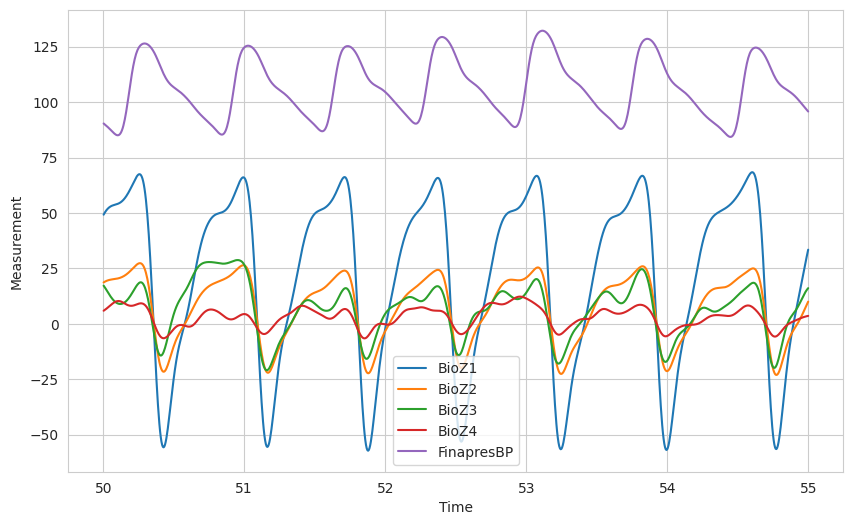

After Alignment


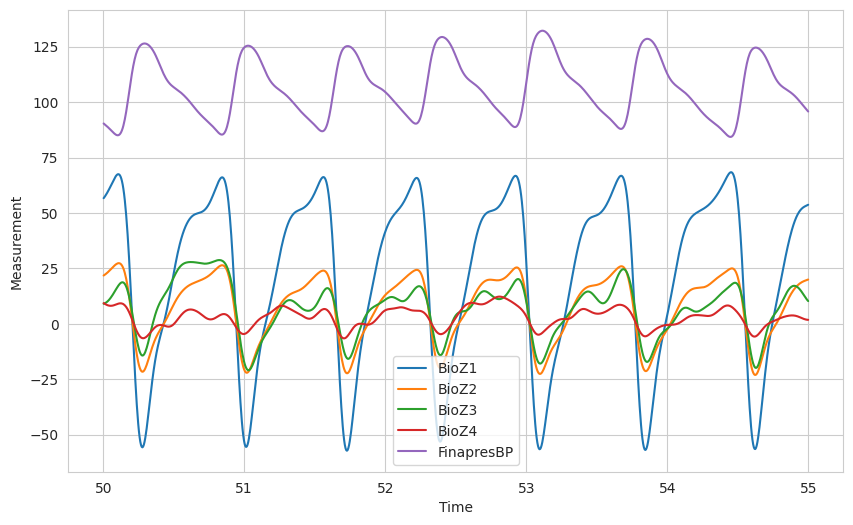

In [67]:
trial_index = (1, 1, 7)  # The selected trial

plot_alignment(df, aligned_df, trial_index, 50, 55)

The alignment remains good here.

Before Alignment


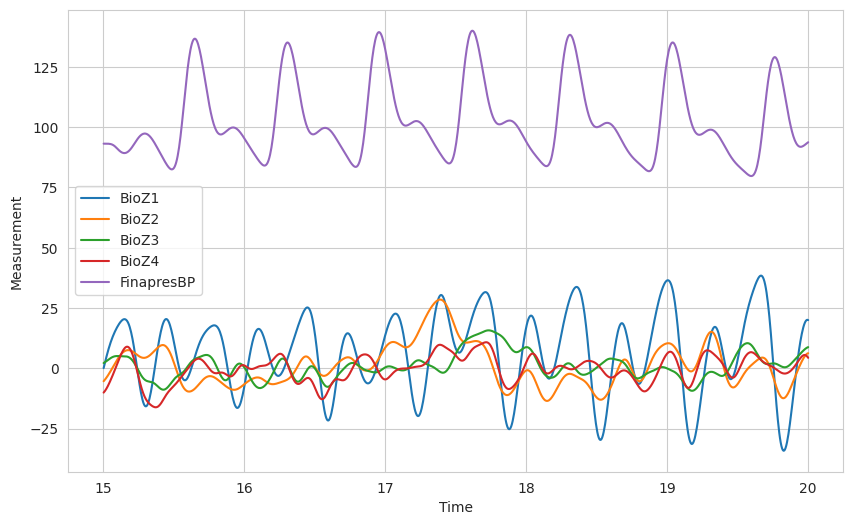

After Alignment


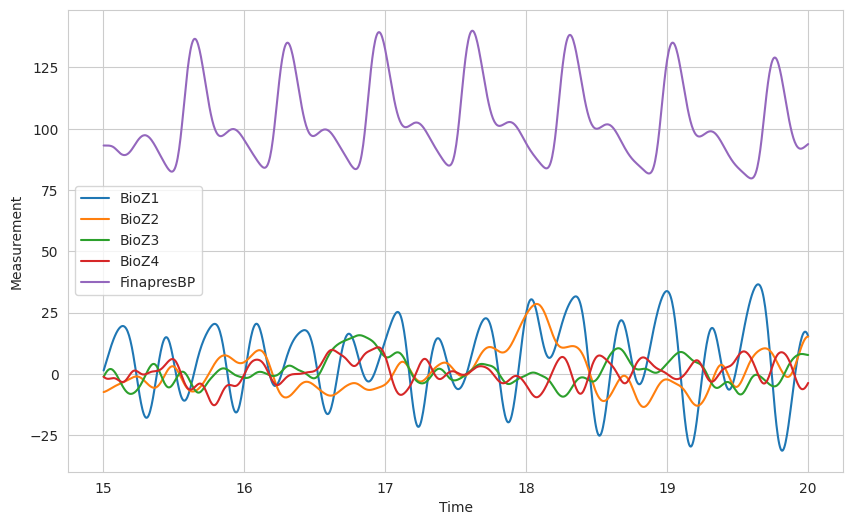

Before Alignment


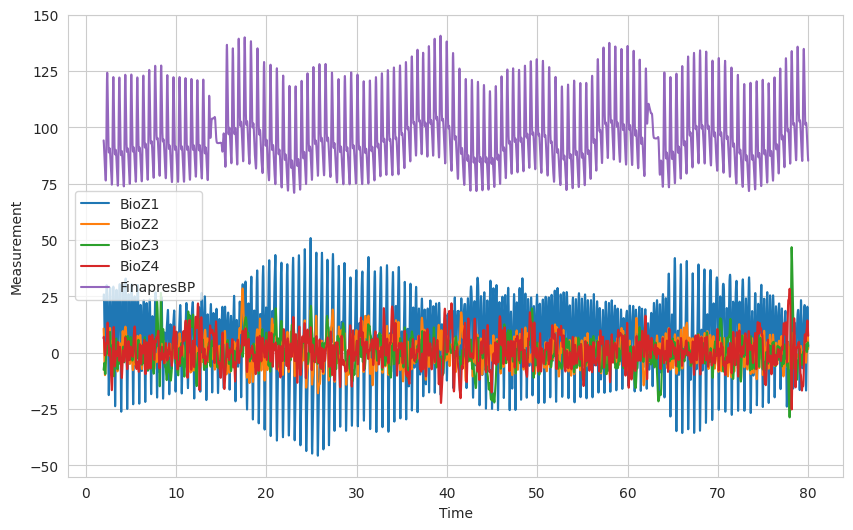

After Alignment


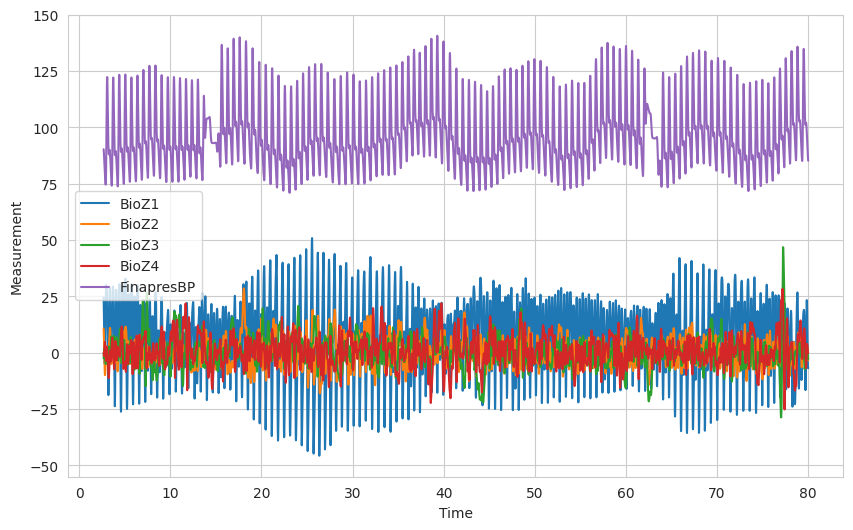

In [68]:
trial_index = (2, 1, 40)

plot_alignment(df, aligned_df, trial_index, 15, 20)

plot_alignment(df, aligned_df, trial_index, 0, 80)

While the series are less less obviously aligned, the majority of the data is kept.

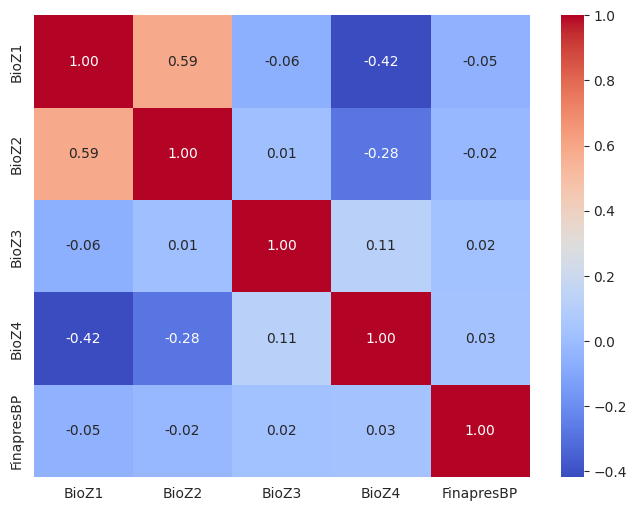

In [69]:
plot_correlation_matrix(aligned_df, columns_to_plot)

In [70]:
grouped_trials = aligned_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Average Metrics:

Mean Absolute Error: 11.026684640277365 +- 2.139771071391626

Root Mean Squared Error: 14.434398720871878 +- 2.4333367235635817

R^2 Score: 0.4917687662483337 +- 0.11912921966935819


The model performs slightly worse with this approach.

# *** Try Scaling ***

In [71]:
from sklearn.preprocessing import StandardScaler

def scale_group(group):
    scaler = StandardScaler()  # Create a new scaler for each group to avoid data leakage
    
    bioz_columns = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']
    group[bioz_columns] = scaler.fit_transform(group[bioz_columns])  # Scale the BioZ columns
    
    return group


grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
# Apply the scaling function to each trial independently
scaled_df = grouped_trials.apply(scale_group).reset_index(drop=True)
scaled_df

/tmp/ipykernel_26596/3092188875.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scaled_df = grouped_trials.apply(scale_group).reset_index(drop=True)


Subject  Day SetupType  Setup  Trial        time     BioZ1     BioZ2  \
0              1    1  baseline      1      1    2.000961  0.571303  0.523882   
1              1    1  baseline      1      1    2.005961  0.457664  0.410335   
2              1    1  baseline      1      1    2.010961  0.333269  0.286026   
3              1    1  baseline      1      1    2.015961  0.198996  0.151907   
4              1    1  baseline      1      1    2.020961  0.055980  0.009187   
...          ...  ...       ...    ...    ...         ...       ...       ...   
4460467        7    1   cycling      1      3  188.974952 -0.359721 -0.028496   
4460468        7    1   cycling      1      3  188.979952 -0.326422 -0.021748   
4460469        7    1   cycling      1      3  188.984952 -0.294010 -0.014883   
4460470        7    1   cycling      1      3  188.989952 -0.262642 -0.007914   
4460471        7    1   cycling      1      3  188.994952 -0.232453 -0.000849   

            BioZ3     BioZ4  FinapresBP  
0       -0.310035  0.218459   117.25990  
1       -0.411463  0.065432   116.50575  
2       -0.518567 -0.095038   115.71514  
3       -0.630198 -0.261357   114.89302  
4       -0.745002 -0.431661   114.04378  
...           ...       ...         ...  
4460467 -0.226807 -0.226807    67.67920  
4460468 -0.219458 -0.219458    67.50756  
4460469 -0.212235 -0.212235    67.33915  
4460470 -0.205197 -0.205197    67.17298  
4460471 -0.198399 -0.198399    67.00795  

[4460472 rows x 11 columns]

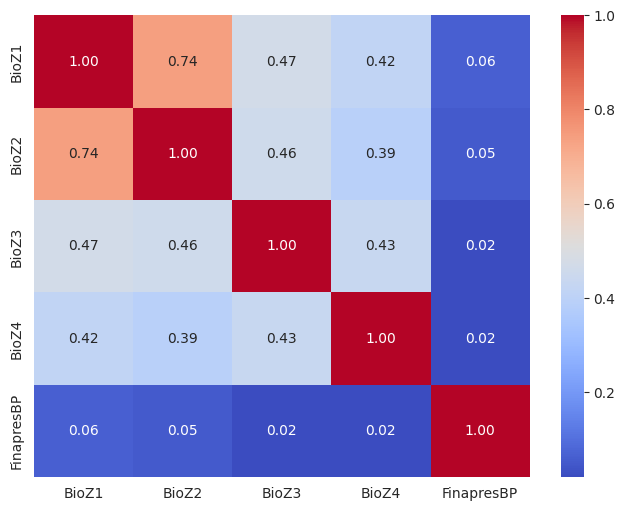

In [72]:
plot_correlation_matrix(scaled_df, columns_to_plot)

In [73]:
grouped_trials = scaled_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Average Metrics:

Mean Absolute Error: 14.738862993364233 +- 1.687263270393464

Root Mean Squared Error: 18.999448614060945 +- 2.0176301150983296

R^2 Score: 0.12184395551361117 +- 0.07983252152391354


In [128]:
grouped_trials = aligned_df.groupby(['Subject', 'Day', 'Trial'])

# Apply the scaling function to each trial independently
scaled_aligned_df = grouped_trials.apply(scale_group).reset_index(drop=True)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_17460\2372416990.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scaled_aligned_df = grouped_trials.apply(scale_group).reset_index(drop=True)


In [129]:
scaled_aligned_df

Subject  Day SetupType  Setup  Trial        time     BioZ1     BioZ2  \
0              1    1  baseline      1      1    2.000961 -1.426844 -1.408522   
1              1    1  baseline      1      1    2.005961 -1.337785 -1.318813   
2              1    1  baseline      1      1    2.010961 -1.245898 -1.226598   
3              1    1  baseline      1      1    2.015961 -1.152396 -1.133099   
4              1    1  baseline      1      1    2.020961 -1.058373 -1.039419   
...          ...  ...       ...    ...    ...         ...       ...       ...   
4440071        7    1   cycling      1      3  188.784952 -0.392288 -0.029291   
4440072        7    1   cycling      1      3  188.789952 -0.358223 -0.022522   
4440073        7    1   cycling      1      3  188.794952 -0.324858 -0.015637   
4440074        7    1   cycling      1      3  188.799952 -0.292382 -0.008646   
4440075        7    1   cycling      1      3  188.804952 -0.260953 -0.001559   

            BioZ3     BioZ4  FinapresBP  
0       -1.256459 -1.089810   117.25990  
1       -1.153369 -0.977816   116.50575  
2       -1.045293 -0.866860   115.71514  
3       -0.933709 -0.757684   114.89302  
4       -0.820069 -0.650735   114.04378  
...           ...       ...         ...  
4440071 -0.242030 -0.242030    78.58829  
4440072 -0.234598 -0.234598    78.16795  
4440073 -0.227162 -0.227162    77.75340  
4440074 -0.219788 -0.219788    77.34540  
4440075 -0.212540 -0.212540    76.94324  

[4440076 rows x 11 columns]

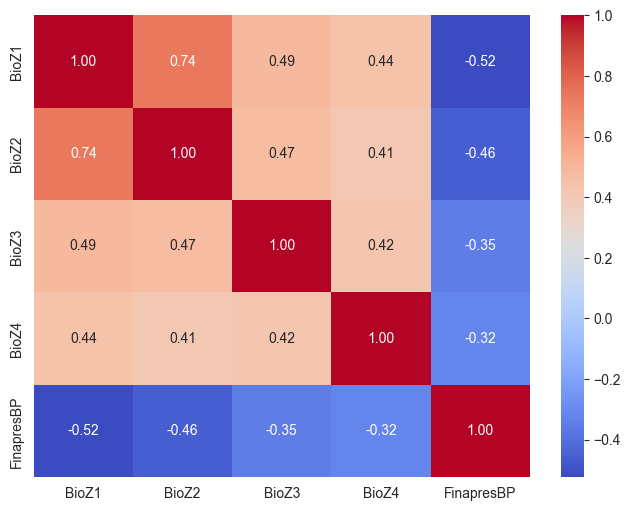

In [130]:
plot_correlation_matrix(scaled_aligned_df, columns_to_plot)

The blood pressure metrics now have quite a prominent correlation with FinapresBP.

In [131]:
grouped_trials = scaled_aligned_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)
train_and_evaluate_rf_regressor(resampled_df)

Average Metrics:
Mean Absolute Error: 11.402022132830433 +- 2.2501615754119424
Root Mean Squared Error: 14.887502992638497 +- 2.5414268230562294
R^2 Score: 0.45874815824373016 +- 0.1306765146953976


Average Metrics:

Mean Absolute Error: 11.402022132830433 +- 2.2501615754119424

Root Mean Squared Error: 14.887502992638497 +- 2.5414268230562294

R^2 Score: 0.45874815824373016 +- 0.1306765146953976


Despite the increased correlation, the performance is slightly worse, probably because scaling only informs the model of the relative BioZ fluctuations within a sample.

I'll try giving the model the raw and scaled BioZ.

In [132]:
scaled_and_raw_df = aligned_df.merge(scaled_aligned_df.drop(columns='FinapresBP'), on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'time'], how='left', suffixes=('', '_scaled'))
scaled_and_raw_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961 -38.533330   
1              1    1  baseline      1      1    2.005961 -34.658723   
2              1    1  baseline      1      1    2.010961 -30.661121   
3              1    1  baseline      1      1    2.015961 -26.593230   
4              1    1  baseline      1      1    2.020961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4440071        7    1   cycling      1      3  188.784952 -14.835259   
4440072        7    1   cycling      1      3  188.789952 -12.991598   
4440073        7    1   cycling      1      3  188.794952 -11.185842   
4440074        7    1   cycling      1      3  188.799952  -9.428160   
4440075        7    1   cycling      1      3  188.804952  -7.727173   

             BioZ2      BioZ3      BioZ4  FinapresBP  BioZ1_scaled  \
0       -14.585256 -10.377965  -3.523223   117.25990     -1.426844   
1       -13.120392  -8.771153  -2.842555   116.50575     -1.337785   
2       -11.614628  -7.086624  -2.168193   115.71514     -1.245898   
3       -10.087884  -5.347416  -1.504652   114.89302     -1.152396   
4        -8.558192  -3.576163  -0.854642   114.04378     -1.058373   
...            ...        ...        ...         ...           ...   
4440071  -1.507162 -20.421111 -20.421111    78.58829     -0.392288   
4440072  -1.269116 -19.776869 -19.776869    78.16795     -0.358223   
4440073  -1.026987 -19.132283 -19.132283    77.75340     -0.324858   
4440074  -0.781154 -18.493100 -18.493100    77.34540     -0.292382   
4440075  -0.531917 -17.864842 -17.864842    76.94324     -0.260953   

         BioZ2_scaled  BioZ3_scaled  BioZ4_scaled  
0           -1.408522     -1.256459     -1.089810  
1           -1.318813     -1.153369     -0.977816  
2           -1.226598     -1.045293     -0.866860  
3           -1.133099     -0.933709     -0.757684  
4           -1.039419     -0.820069     -0.650735  
...               ...           ...           ...  
4440071     -0.029291     -0.242030     -0.242030  
4440072     -0.022522     -0.234598     -0.234598  
4440073     -0.015637     -0.227162     -0.227162  
4440074     -0.008646     -0.219788     -0.219788  
4440075     -0.001559     -0.212540     -0.212540  

[4440076 rows x 15 columns]

In [133]:
grouped_trials = scaled_and_raw_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

features = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'BioZ1_scaled', 'BioZ2_scaled', 'BioZ3_scaled', 'BioZ4_scaled']
# train_and_evaluate_rf_regressor(resampled_df, features=features, show_subject_performance=True)

Metrics for Subject 1:
Mean Absolute Error: 6.928135766935553
Root Mean Squared Error: 9.328699389179848
R^2 Score: 0.7339787864345848

Metrics for Subject 2:
Mean Absolute Error: 8.78679113661634
Root Mean Squared Error: 11.974240065379313
R^2 Score: 0.5917287037533367

Metrics for Subject 3:
Mean Absolute Error: 9.895162689707586
Root Mean Squared Error: 13.737202123402867
R^2 Score: 0.6458014229523092

Metrics for Subject 4:
Mean Absolute Error: 11.033388980004275
Root Mean Squared Error: 14.322457893675809
R^2 Score: 0.5133810036241826

Metrics for Subject 5:
Mean Absolute Error: 9.859955474549475
Root Mean Squared Error: 12.90652725150073
R^2 Score: 0.6483822427501884

Metrics for Subject 6:
Mean Absolute Error: 11.2977857099431
Root Mean Squared Error: 14.85379783446197
R^2 Score: 0.5237476365686433

Metrics for Subject 7:
Mean Absolute Error: 7.153243853852846
Root Mean Squared Error: 10.468456317369736
R^2 Score: 0.6755954561266033

Average Metrics:
Mean Absolute Error: 9.27920

Metrics for Subject 1:
Mean Absolute Error: 6.928135766935553
Root Mean Squared Error: 9.328699389179848
R^2 Score: 0.7339787864345848

Metrics for Subject 2:
Mean Absolute Error: 8.78679113661634
Root Mean Squared Error: 11.974240065379313
R^2 Score: 0.5917287037533367

Metrics for Subject 3:
Mean Absolute Error: 9.895162689707586
Root Mean Squared Error: 13.737202123402867
R^2 Score: 0.6458014229523092

Metrics for Subject 4:
Mean Absolute Error: 11.033388980004275
Root Mean Squared Error: 14.322457893675809
R^2 Score: 0.5133810036241826

Metrics for Subject 5:
Mean Absolute Error: 9.859955474549475
Root Mean Squared Error: 12.90652725150073
R^2 Score: 0.6483822427501884

Metrics for Subject 6:
Mean Absolute Error: 11.2977857099431
Root Mean Squared Error: 14.85379783446197
R^2 Score: 0.5237476365686433

Metrics for Subject 7:
Mean Absolute Error: 7.153243853852846
Root Mean Squared Error: 10.468456317369736
R^2 Score: 0.6755954561266033

Average Metrics:
Mean Absolute Error: 9.279209087372738 +- 1.6105994116558155
Root Mean Squared Error: 12.513054410710039 +- 1.890472291862806
R^2 Score: 0.6189450360299784 +- 0.07461988152520477


Much better, I'll try again using trial stats instead of the raw BioZ metrics.

In [143]:
aggregations = {
    'BioZ1': ['mean', 'std', 'min', 'max', 'median', 
            lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'BioZ2': ['mean', 'std', 'min', 'max', 'median', 
            lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'BioZ3': ['mean', 'std', 'min', 'max', 'median', 
            lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'BioZ4': ['mean', 'std', 'min', 'max', 'median', 
            lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
}

# Use groupby to group the DataFrame and then apply the aggregations
stats_df = aligned_df.groupby(['Subject', 'Day', 'Trial']).agg(aggregations)

# Flatten the MultiIndex columns and create custom names for each statistic
stats_df.columns = ['_'.join(col).rstrip('_') for col in stats_df.columns.values]

# Reset index if you want the groupby columns back as normal columns
stats_df.reset_index(inplace=True)
stats_df

Subject  Day  Trial  BioZ1_mean  BioZ1_std   BioZ1_min   BioZ1_max  \
0          1    1      1   23.542827  43.507199  -81.195066   89.653726   
1          1    1      2   27.661086  42.312082  -84.615232   94.297120   
2          1    1      3   18.313425  38.548162  -70.072198   79.367466   
3          1    1      4   15.875111  38.424987  -69.128253   81.295965   
4          1    1      5   15.834207  37.168574  -67.495082   77.784891   
..       ...  ...    ...         ...        ...         ...         ...   
255        6    1     39  -10.324857  25.373721 -108.776480  138.469681   
256        6    1     40  -10.817136  22.698238  -92.147561  163.307044   
257        7    1      1   25.417394  48.956768 -116.019814  130.599311   
258        7    1      2   25.157984  58.834157 -165.637787  172.917475   
259        7    1      3    6.396002  54.122319 -364.278732  279.972622   

     BioZ1_median  BioZ1_<lambda_0>  BioZ1_<lambda_1>  ...  BioZ3_median  \
0       34.817938         -5.799280         59.758393  ...     10.491305   
1       44.274756         -0.760265         61.410601  ...     13.410143   
2       30.789702        -11.951972         50.513939  ...      6.473159   
3       24.998954        -13.886445         48.914893  ...      3.653695   
4       25.347772        -12.478234         46.309978  ...      7.023358   
..            ...               ...               ...  ...           ...   
255     -9.977720        -22.297511          1.390293  ...     -2.800366   
256     -9.024238        -22.218738          2.070314  ...     -1.173045   
257     33.899197         -9.063737         64.788272  ...      6.260377   
258     36.712022        -19.675233         71.222674  ...      2.990903   
259      7.011512        -27.220617         42.113661  ...      0.535649   

     BioZ3_<lambda_0>  BioZ3_<lambda_1>  BioZ4_mean  BioZ4_std   BioZ4_min  \
0           -1.163999         19.354620    3.100357   6.077920  -13.406627   
1            1.397415         21.241850    3.626024   5.775663  -15.339632   
2           -4.044105         14.405782    1.296489   6.119077  -20.347102   
3           -7.435656         14.355562    1.186888  11.428380 -142.785041   
4           -3.433858         14.116764    0.966066   8.114932  -56.101536   
..                ...               ...         ...        ...         ...   
255        -11.852421          8.592798   -0.005707   5.913959  -23.667778   
256        -11.922206         10.906113    0.969015   5.601574  -16.433657   
257         -5.193362         14.607896    4.479666  14.873914  -63.986413   
258        -11.106853         15.916858    0.822991  50.832648 -390.501220   
259        -15.373001         17.297589    0.558352  86.682338 -585.891283   

      BioZ4_max  BioZ4_median  BioZ4_<lambda_0>  BioZ4_<lambda_1>  
0     18.657069      4.060137         -1.379593          7.609565  
1     18.260691      4.799484         -0.408824          7.887595  
2     18.483764      1.719879         -3.177883          5.887953  
3     98.845993      1.445305         -4.028229          6.342882  
4     21.557553      1.697975         -3.623488          6.297981  
..          ...           ...               ...               ...  
255   38.246842      0.089069         -3.614551          3.757130  
256   24.478452      0.675370         -3.225475          5.042238  
257   77.313664      6.260377         -5.193362         14.607896  
258  380.955862      2.990903        -11.106853         15.916858  
259  599.956638      0.535649        -15.373001         17.297589  

[260 rows x 31 columns]

In [144]:
scaled_and_stats_df = scaled_df.merge(stats_df, on=['Subject', 'Day', 'Trial'], how='left', suffixes=('_scaled', ''))
scaled_and_stats_df

Subject  Day SetupType  Setup  Trial        time     BioZ1     BioZ2  \
0              1    1  baseline      1      1    2.000961  0.571303  0.523882   
1              1    1  baseline      1      1    2.005961  0.457664  0.410335   
2              1    1  baseline      1      1    2.010961  0.333269  0.286026   
3              1    1  baseline      1      1    2.015961  0.198996  0.151907   
4              1    1  baseline      1      1    2.020961  0.055980  0.009187   
...          ...  ...       ...    ...    ...         ...       ...       ...   
4460467        7    1   cycling      1      3  188.974952 -0.359721 -0.028496   
4460468        7    1   cycling      1      3  188.979952 -0.326422 -0.021748   
4460469        7    1   cycling      1      3  188.984952 -0.294010 -0.014883   
4460470        7    1   cycling      1      3  188.989952 -0.262642 -0.007914   
4460471        7    1   cycling      1      3  188.994952 -0.232453 -0.000849   

            BioZ3     BioZ4  ...  BioZ3_median  BioZ3_<lambda_0>  \
0       -0.310035  0.218459  ...     10.491305         -1.163999   
1       -0.411463  0.065432  ...     10.491305         -1.163999   
2       -0.518567 -0.095038  ...     10.491305         -1.163999   
3       -0.630198 -0.261357  ...     10.491305         -1.163999   
4       -0.745002 -0.431661  ...     10.491305         -1.163999   
...           ...       ...  ...           ...               ...   
4460467 -0.226807 -0.226807  ...      0.535649        -15.373001   
4460468 -0.219458 -0.219458  ...      0.535649        -15.373001   
4460469 -0.212235 -0.212235  ...      0.535649        -15.373001   
4460470 -0.205197 -0.205197  ...      0.535649        -15.373001   
4460471 -0.198399 -0.198399  ...      0.535649        -15.373001   

         BioZ3_<lambda_1>  BioZ4_mean  BioZ4_std   BioZ4_min   BioZ4_max  \
0               19.354620    3.100357   6.077920  -13.406627   18.657069   
1               19.354620    3.100357   6.077920  -13.406627   18.657069   
2               19.354620    3.100357   6.077920  -13.406627   18.657069   
3               19.354620    3.100357   6.077920  -13.406627   18.657069   
4               19.354620    3.100357   6.077920  -13.406627   18.657069   
...                   ...         ...        ...         ...         ...   
4460467         17.297589    0.558352  86.682338 -585.891283  599.956638   
4460468         17.297589    0.558352  86.682338 -585.891283  599.956638   
4460469         17.297589    0.558352  86.682338 -585.891283  599.956638   
4460470         17.297589    0.558352  86.682338 -585.891283  599.956638   
4460471         17.297589    0.558352  86.682338 -585.891283  599.956638   

         BioZ4_median  BioZ4_<lambda_0>  BioZ4_<lambda_1>  
0            4.060137         -1.379593          7.609565  
1            4.060137         -1.379593          7.609565  
2            4.060137         -1.379593          7.609565  
3            4.060137         -1.379593          7.609565  
4            4.060137         -1.379593          7.609565  
...               ...               ...               ...  
4460467      0.535649        -15.373001         17.297589  
4460468      0.535649        -15.373001         17.297589  
4460469      0.535649        -15.373001         17.297589  
4460470      0.535649        -15.373001         17.297589  
4460471      0.535649        -15.373001         17.297589  

[4460472 rows x 39 columns]

In [145]:
grouped_trials = scaled_and_stats_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

features = scaled_and_stats_df.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'time', 'FinapresBP']).columns
# train_and_evaluate_rf_regressor(resampled_df, features=features)

Average Metrics:
Mean Absolute Error: 11.167092072866739 +- 1.0555773814265383
Root Mean Squared Error: 14.91856947676757 +- 1.498468059518494
R^2 Score: 0.4536069891720194 +- 0.09109046613214868


Average Metrics:

Mean Absolute Error: 11.167092072866739 +- 1.0555773814265383

Root Mean Squared Error: 14.91856947676757 +- 1.498468059518494

R^2 Score: 0.4536069891720194 +- 0.09109046613214868

A bit worse.

---

### **2. Machine Learning**

I am going to focus on regression models to predict blood pressure exploring two main approaches.

##### **1. Individual Subject Model**
-  This would be similar to the approach from the paper, training a model on each subject individually, that attempts to predict the blood pressure in the second half of a trial, using just the BioZ metrics.

- If this works, a patient could be calibrated using a gold standard FinapresBP measurement, then they could leave and rely solely on the BioZ sensor to monitor blood pressure.

##### **2. Cross-Subject Prediction Model**
-  Training a model on 6 subjects, then predicting the blood pressure of a 7th.

- If this proves to be accurate, future patients would only need to use the BioZ sensor to keep track of their blood pressure.